# 1. Chargement du dataset

In [1]:
csv_pvf10 = "../data/processed/structure_pvf_10.csv"
results_dir = "ML_images_results_RF"

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Charger le dataframe à partir du dataset
def load_df_from_dataset(csv_path,*,format,originalTrainTest=False,removeCarre=False):
    # Charger le fichier CSV et filtrer sur le format sélectionné
    df_pvf10 = pd.read_csv(csv_path)
    df_pvf10 = df_pvf10.loc[(df_pvf10['Format'] == format)]
    # Si on utilise le découpage train/test proposé par les créateurs du dataset
    if originalTrainTest:
        df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
        df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
        X_train = df_train.drop('Classe',axis=1)
        y_train = df_train['Classe']
        X_test = df_test.drop('Classe',axis=1)
        y_test = df_test['Classe']
    # Sinon si on retire les images carrées mises en doute lors de l'analyse exploratoire
    elif removeCarre:
        df_pvf10 = df_pvf10.loc[~df_pvf10['Doute_Carre']]
        # découpage train/test en 80/20 avec conservation de la répartition des classes
        X = df_pvf10.drop('Classe',axis=1)
        y = df_pvf10['Classe']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    # Sinon découpage train/test en 80/20 avec conservation de la répartition des classes
    else:
        X = df_pvf10.drop('Classe',axis=1)
        y = df_pvf10['Classe']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60")
print ("Nb d'images ensemble d'entraînement :",X_train.shape[0])
print ("Nb d'images ensemble de test :",X_test.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test.value_counts(normalize=True))

pd.set_option('display.max_columns', None)

Nb d'images ensemble d'entraînement : 4457
Nb d'images ensemble de test : 1115
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271932
hot cell                  0.169396
junction box heat         0.143594
substring open circuit    0.106574
short circuit panel       0.076509
Debris cover              0.073592
bottom dirt               0.067759
shadow                    0.054297
break                     0.023558
string short circuit      0.012789
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de test :
Classe
healthy panel             0.271749
hot cell                  0.169507
junction box heat         0.143498
substring open circuit    0.106726
short circuit panel       0.077130
Debris cover              0.073543
bottom dirt               0.067265
shadow                    0.054709
break                     0.023318
string short circuit      0.012556
Name: proportion, dtype: float64


# 2. Définition de transformeurs pour extraction de features

### Transformeur 1 : vecteurs HOG

In [3]:
import cv2
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin

# Transformeur qui renvoie le dataframe des vecteurs HOG
class HOGExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110), pixels_per_cell=(8,8),cells_per_block=(2,2)):
        self.image_size = image_size
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.feature_names_ = None

    # Méthode d'extraction du vecteur HOG d'une image
    def extract_hog(self, gray_img):
        hog_vector = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            feature_vector=True
        )
        return hog_vector
    
    # Le fit ne sert qu'à récupérer le nom des features créées
    def fit(self, X, y=None):
        # On utilise une seule image
        img = cv2.imread(X['Chemin'].iloc[0])
        # Conversion en niveaux de gris et resizing
        img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
        # Extraction du vecteur HOG
        hog_vector = self.extract_hog(img_gray_resized)
        # On en déduit le nom des features
        self.feature_names_ =  [f'HOG_{i+1}' for i in range(len(hog_vector))]
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs HOG
        hog_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur HOG
            hog_vector = self.extract_hog(img_gray_resized)
            hog_vectors.append(hog_vector)
        # On renvoie le dataframe des vecteurs HOG
        return pd.DataFrame(hog_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 2 : vecteurs GLCM 

In [4]:
from skimage.feature import graycomatrix, graycoprops

# Transformeur qui renvoie le dataframe des caractéristiques GLCM
class GLCMExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),
                 glcm_distances=[1],
                 glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                 glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']):
        self.image_size = image_size
        self.glcm_distances = glcm_distances
        self.glcm_angles = glcm_angles
        self.glcm_props = glcm_props
        # On détermine le nom des features GLCM à extraire
        self.feature_names_ = []
        # Pour chaque propriété, chaque distance et chaque angle
        for prop in self.glcm_props:
            for distance in self.glcm_distances:
                for angle in self.glcm_angles:
                    # On stocke dans les noms des features un label du type : contrast_d1_a45
                    self.feature_names_.append(f"{prop}_d{distance}_a{np.degrees(angle):.0f}")

    # Méthode d'extraction des caractéristiques GLCM d'une image
    def extract_glcm(self, gray_img):
        glcm_vector = []
        # Calcul de la matrice GLCM (256 x 256 x distances x angles)
        glcm = graycomatrix(
            gray_img,
            distances=self.glcm_distances,
            angles=self.glcm_angles,
            levels=256
        )
        # Pour chaque propriété GLCM
        for prop in self.glcm_props:
            # On la calcule pour les différentes distances et les différents angles 
            prop_matrix = graycoprops(glcm, prop)  # Matrice distances x angles
            # On transforme la matrice en vecteur qu'on stocke dans glcm_vector
            glcm_vector.extend(prop_matrix.flatten())
        return glcm_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs GLCM
        glcm_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur GLCM
            glcm_vector = self.extract_glcm(img_gray_resized)
            glcm_vectors.append(glcm_vector)
        # On renvoie le dataframe des vecteurs GLCM
        return pd.DataFrame(glcm_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 3 : vecteurs Entropie

In [5]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.stats import skew, kurtosis

# Transformeur qui renvoie le dataframe des caractéristiques de l'entropie
class EntropyExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),radius=4, bins=10, include_histogram=True):
        self.image_size = image_size
        self.radius = radius
        self.bins = bins
        self.include_histogram = include_histogram
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['entropy_mean', 'entropy_std', 'entropy_min','entropy_max', 'entropy_median', 'entropy_skew', 'entropy_kurtosis']
        # Si histogramme demandé
        if include_histogram:
            self.feature_names_.extend([f'entropy_hist_bin{i+1}' for i in range(self.bins)])
        
    # Méthode d'extraction des caractéristiques de l'entropie d'une image
    def extract_entropy(self, gray_img):
        # Calcul de la carte d'entropie
        entropie = entropy(gray_img, disk(self.radius))
        # Calcul des statistiques associées
        entropy_vector = [
                np.mean(entropie),
                np.std(entropie),
                np.min(entropie),
                np.max(entropie),
                np.median(entropie),
                skew(entropie.ravel()),
                kurtosis(entropie.ravel())
            ]
        # Si histogramme demandé
        if (self.include_histogram):
            hist, bin_edges = np.histogram(entropie, bins=self.bins, range=(0, np.max(entropie)), density=True)
            # On l'ajoute au vecteur des caractéristiques de l'entropie
            entropy_vector.extend(list(hist))

        return entropy_vector      

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs caractéristiques de l'entropie
        entropy_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur de l'entropie
            entropy_vector = self.extract_entropy(img_gray_resized)
            entropy_vectors.append(entropy_vector)
        # On renvoie le dataframe des vecteurs de l'entropie
        return pd.DataFrame(entropy_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 4 : densité de contours

In [6]:
from skimage.filters.rank import entropy

# Transformeur qui renvoie le dataframe des densités de contours
class EdgeDensityExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(60,110),canny_threshold1=100,canny_threshold2=200):
        self.image_size = image_size
        self.canny_threshold1 = canny_threshold1
        self.canny_threshold2 = canny_threshold2
        # On détermine le nom des features Entropie à extraire
        self.feature_names_ = ['edge_density']
        
    # Méthode d'extraction de le densité de contours d'une image
    def extract_edge_density(self, gray_img):
        edges = cv2.Canny(gray_img, self.canny_threshold1, self.canny_threshold2)
        return np.sum(edges > 0) / edges.size     

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les densités de contours
        edge_densities = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage de la densité de contour (on rogne 2 pixels sur les bords)
            edge_density = self.extract_edge_density(img_gray_resized[2:self.image_size[1]-1,2:self.image_size[0]-1])
            edge_densities.append(edge_density)
        # On renvoie le dataframe des densités de contours (1 feature)
        return pd.DataFrame({self.feature_names_[0]:edge_densities},index=X.index)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

### Transformeur 5 : pixels bruts

In [7]:
# Transformeur qui renvoie le dataframe des pixels bruts
class PixelsBrutsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(30,55)):
        self.image_size = image_size
        # Nom des features : Pixel1, Pixel2...
        self.feature_names_ = [f"Pixel{i+1}" for i in range(image_size[0]*image_size[1])]  

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # On va calculer les vecteurs des pixels bruts
        brut_vectors = []
        # On parcourt les chemins des images
        for img_path in X['Chemin']:
            # Lecture de l'image
            img = cv2.imread(img_path)
            # Conversion en niveaux de gris et resizing
            img_gray_resized = cv2.cvtColor(cv2.resize(img, self.image_size), cv2.COLOR_BGR2GRAY)
            # Extraction et stockage du vecteur des pixels bruts
            brut_vector = img_gray_resized.flatten()
            brut_vectors.append(brut_vector)
        # On renvoie le dataframe des vecteurs des pixels bruts
        return pd.DataFrame(brut_vectors,index=X.index,columns=self.feature_names_)
    
    # Pour récupération du nom des features créées
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_
    
# Création du transformeur
pixbrut_extr = PixelsBrutsExtractor()

### Transformeur 6 : réduction de dimensions basée sur UMAP

In [8]:
import umap

class UMAPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=15, n_components=2, min_dist=0.1):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.min_dist = min_dist
        self.umap = None

    def fit(self, X, y=None):
        self.umap = umap.UMAP(
            n_neighbors=self.n_neighbors,
            n_components=self.n_components,
            min_dist=self.min_dist,
            random_state=42
        )
        self.umap.fit(X)
        return self

    def transform(self, X):
        return self.umap.transform(X)

d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Définition d'une pipeline et grille de paramétrage

### Pipeline preprocessing + Random Forest : étapes par défaut

In [9]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.feature_selection import SelectPercentile,mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler,ClusterCentroids
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.ensemble import RandomForestClassifier

# Pour les extracteurs, on part sur les paramètres utilisés lors de l'analyse exploratoire
default_steps = {
    'hog':HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(2,2)),
    'glcm':GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                         glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
    'entropie':EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=True),
    'canny':EdgeDensityExtractor(image_size=(60,110),canny_threshold1=100,canny_threshold2=200),
    'brut':PixelsBrutsExtractor(image_size=(30,55)),
    'scaler':StandardScaler(),
    'reduction':PCA(0.9),
    'sampler':SMOTE(),
    'clf':RandomForestClassifier()                       
}
# Pipeline = extraction des features + mise à l'échelle + sélection/réduction + rééchantillonnage + classifieur
# Rmq : pour RandomForest basé sur les arbres de décision, la mise à l'échelle ne servira qu'en cas d'application d'une réduction de dimensions
pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', default_steps['hog']),
        ('glcm', default_steps['glcm']),
        ('entropie',default_steps['entropie']),
        ('canny',default_steps['canny']),
        ('brut',default_steps['brut'])
    ])),
    ('scaler', default_steps['scaler']),
    ('reduction', default_steps['reduction']),
    ('sampler', default_steps['sampler']),
    ('clf', default_steps['clf'])
])


### Grille de paramétrage dynamique

Pour un temps de calcul raisonnable, nous ne pouvons pas appliquer une seule grille de paramétrage pour l'ensemble des étapes de la pipeline. Les combinaisons possibles d'extraction, de mise à l'échelle, de réduction de dimension, de rééchantillonnage et d'hyperparamètres du classifieur sont beaucoup trop nombreuses.

On va ainsi fixer des **grilles de paramétrage par étape** :
- d'abord on cherchera les paramètres optimaux pour chacun des 5 extracteurs 
- ensuite on testera différentes combinaisons d'extraction
- une fois cette partie d'extraction choisie, on optimisera la réduction de dimensions (précédée d'une standardisation) et les hyperparamètres du classifieur
- puis on testera des techniques de rééchantillonnage

C'est pourquoi nous allons faire une fonction de construction "dynamique" d'une grille de paramétrage. Pour chaque étape de la pipeline, 3 options sont possibles :
- "no" => on n'applique pas l'étape
- "one" => on applique le transformeur par défaut pour cette étape
- "all" => on teste toutes les possibilités listées pour cette étape



In [10]:
# Fonction de construction d'une grille de paramétrage pour la pipeline
def build_param_grid(default_steps,*,brut="no", hog="no", glcm="no",entropie="no", canny="no", scaler="no", reduction="no", sampler="no", clf="one"):
    param_grid = {}

    # Étapes d'extraction des features

    # Si aucune extraction
    if brut=="no" and hog=="no" and glcm=="no" and entropie=="no" and canny=="no":
        # On conserve les données d'entrée de la pipeline
        param_grid['features'] = ['passthrough']
    # Si au moins une étape d'extraction
    else:

        # Pour HOG
        if hog=="all":
            # On fait varier pixels_per_cell et cells_per_block
            param_grid['features__hog'] = [HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(2,2)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(8,8),cells_per_block=(3,3)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(2,2)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(16,16),cells_per_block=(2,2)),
                                        HOGExtractor(image_size=(60,110),pixels_per_cell=(16,16),cells_per_block=(3,3))]
        elif hog=="one":
            param_grid['features__hog'] = [default_steps['hog']]
        else:
            param_grid['features__hog'] = ['drop']

        # Pour GLCM
        if glcm=="all":
            # On fait varier la distance de voisinage des pixels observés et les propriétés à calculer
            # (d'abord toutes les propriétés, puis uniquement contraste et énergie qui semblaient les plus prometteuses lors de l'analyse exploratoire)
            param_grid['features__glcm'] = [GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[4],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','dissimilarity','homogeneity','energy','correlation']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[1],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','energy']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[4],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','energy']),
                                            GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                                        glcm_props=['contrast','energy'])]
        elif glcm=="one":
            param_grid['features__glcm'] = [default_steps['glcm']]
        else:
            param_grid['features__glcm'] = ['drop']

        # Pour Entropie
        if entropie=="all":
            # On fait varier la taille du disque d'entropie et l'utilisation ou non d'un histogramme en plus des statistiques de l'entropie
            param_grid['features__entropie'] = [EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=10, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=20, include_histogram=True),
                                                EntropyExtractor(image_size=(60,110),radius=4, bins=10, include_histogram=False),
                                                EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=False),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=10, include_histogram=False),
                                                EntropyExtractor(image_size=(60,110),radius=2, bins=20, include_histogram=False)]
        elif entropie=="one":
            param_grid['features__entropie'] = [default_steps['entropie']]
        else:
            param_grid['features__entropie'] = ['drop']
        
        # Pour Canny
        if canny=="all":
            # On fait varier les seuils du filtre de Canny
            param_grid['features__canny'] = [EdgeDensityExtractor(image_size=(60,110),canny_threshold1=100,canny_threshold2=200),
                                            EdgeDensityExtractor(image_size=(60,110),canny_threshold1=50,canny_threshold2=150),
                                            EdgeDensityExtractor(image_size=(60,110),canny_threshold1=30,canny_threshold2=100),
                                            EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)]
        elif canny=="one":
            param_grid['features__canny'] = [default_steps['canny']]
        else:
            param_grid['features__canny'] = ['drop']

        # Pour Pixels bruts
        if brut=="all":
            # On fait varier la taille de l'image pour l'extraction des pixels bruts
            param_grid['features__brut'] = [PixelsBrutsExtractor(image_size=(30,55)),
                                            PixelsBrutsExtractor(image_size=(60,110)),
                                            PixelsBrutsExtractor(image_size=(45,83)),
                                            PixelsBrutsExtractor(image_size=(15,28))]
        elif brut=="one":
            param_grid['features__brut'] = [default_steps['brut']]
        else:
            param_grid['features__brut'] = ['drop']

    # Mise à l'échelle
    if scaler=="all":
        param_grid['scaler'] = [StandardScaler()] # Juste une standardisation à utiliser en cas de réduction de dimensions
    elif scaler =="one":
        param_grid['scaler'] = [default_steps['scaler']]
    else:
        param_grid['scaler'] =['passthrough']

    # Réduction de dimension
    if reduction == "all":
        param_grid['reduction'] = [SelectPercentile(mutual_info_classif,percentile=10),SelectPercentile(mutual_info_classif,percentile=20),
                                   PCA(0.9),PCA(0.95),PCA(0.99),
                                   LDA()]
    elif reduction == "one":
        param_grid['reduction'] = [default_steps['reduction']]
    else:
        param_grid['reduction'] = ['passthrough']

    # Rééchantillonnage
    if sampler== "all":
        param_grid['sampler'] = [RandomOverSampler(),SMOTE(),ADASYN(),
                                 RandomUnderSampler(),ClusterCentroids(),
                                 SMOTETomek(),SMOTEENN(),
                                 'passthrough']
    elif sampler== "one":
        param_grid['sampler'] = [default_steps['sampler']]
    else:
        param_grid['sampler'] = ['passthrough']

    # Hyperparamètres du classifieur Random Forest
    if clf== "all":
        param_grid['clf__n_estimators'] = [100,200]
        param_grid['clf__max_depth'] = [None,10,20]
        param_grid['clf__min_samples_split'] = [2,5]
        param_grid['clf__min_samples_leaf'] = [1,2]
        param_grid['clf__criterion'] = ['gini','entropy']
    else:
        param_grid['clf'] = [default_steps['clf']]

    return param_grid

### Fonction de validation croisée

In [11]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Fonction de validation croisée d'une pipeline avec GridSearch
def cross_validation(pipe,param_grid,X_train,y_train) : 
    # Création d'une Grid Search avec 5 folds (avec répartition des classes conservée)
    # On cherche le meilleur f1-score macro
    pipe_grid = GridSearchCV(pipe,param_grid,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                         scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},refit='f1_macro',n_jobs=-1)
    # Entraînement
    pipe_grid.fit(X_train,y_train)
    # Affichage des résultats (classement par f1-score macro)
    cv_results = pd.DataFrame(pipe_grid.cv_results_).sort_values('mean_test_f1_macro',ascending=False)
    display (cv_results)
    print ("Best params (f1 macro) : ",pipe_grid.best_params_)
    print ("Best score (f1 macro): ",pipe_grid.best_score_)
    # Renvoyer les résultats de la cross-validation et un dico avec la meilleure pipeline fittée, ses paramètres et ses scores
    best_idx = pipe_grid.best_index_
    dico_best_pipe = {
        "fitted_pipe":pipe_grid.best_estimator_,
        "params":pipe_grid.best_params_,
        "mean_accuracy":cv_results.loc[best_idx, 'mean_test_accuracy'],
        "std_accuracy":cv_results.loc[best_idx, 'std_test_accuracy'],
        "mean_f1_macro":cv_results.loc[best_idx, 'mean_test_f1_macro'],
        "std_f1_macro":cv_results.loc[best_idx, 'std_test_f1_macro'],
        "mean_fit_time":cv_results.loc[best_idx, 'mean_fit_time'],
        "mean_score_time":cv_results.loc[best_idx, 'mean_score_time']
        }
    return cv_results,dico_best_pipe

# 4. Optimisation des extracteurs

Avant de voir quelle combinaison d'extracteurs est la plus prometteuse, on commence par tester les différents paramètres d'extracteurs avec une pipeline simple : extracteur + Random Forest 

### Validation croisée HOG + Random Forest

In [28]:
# GridSearch HOG + Random Forest
param_grid = build_param_grid(default_steps,hog="all",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3      46.010982      0.414760         3.673818        0.154067   
5      18.765191      2.009123         1.400884        0.172815   
2      40.466538      0.486175         3.468020        0.149815   
1      71.100969      0.710026        15.020119        8.357502   
4      23.243176      0.285387         2.288236        0.096541   
0      60.038982      0.788947        33.069228        1.446892   

                  param_clf param_features__brut param_features__canny  \
3  RandomForestClassifier()                 drop                  drop   
5  RandomForestClassifier()                 drop                  drop   
2  RandomForestClassifier()                 drop                  drop   
1  RandomForestClassifier()                 drop                  drop   
4  RandomForestClassifier()                 drop                  drop   
0  RandomForestClassifier()                 drop                  drop   

  param_features__entropie param_features__glcm  \
3                     drop                 drop   
5                     drop                 drop   
2                     drop                 drop   
1                     drop                 drop   
4                     drop                 drop   
0                     drop                 drop   

                                 param_features__hog param_reduction  \
3  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   
5  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   
2             HOGExtractor(pixels_per_cell=(12, 12))     passthrough   
1               HOGExtractor(cells_per_block=(3, 3))     passthrough   
4             HOGExtractor(pixels_per_cell=(16, 16))     passthrough   
0                                     HOGExtractor()     passthrough   

  param_sampler param_scaler  \
3   passthrough  passthrough   
5   passthrough  passthrough   
2   passthrough  passthrough   
1   passthrough  passthrough   
4   passthrough  passthrough   
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
3  {'clf': RandomForestClassifier(), 'features__b...              0.701794   
5  {'clf': RandomForestClassifier(), 'features__b...              0.627803   
2  {'clf': RandomForestClassifier(), 'features__b...              0.696188   
1  {'clf': RandomForestClassifier(), 'features__b...              0.702915   
4  {'clf': RandomForestClassifier(), 'features__b...              0.637892   
0  {'clf': RandomForestClassifier(), 'features__b...              0.682735   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
3              0.704036              0.714927              0.711560   
5              0.643498              0.641975              0.632997   
2              0.695067              0.700337              0.692480   
1              0.696188              0.692480              0.682379   
4              0.632287              0.617284              0.639731   
0              0.676009              0.683502              0.671156   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
3              0.685746            0.703613           0.010138   
5              0.632997            0.635854           0.005951   
2              0.676768            0.692168           0.008106   
1              0.665544            0.687901           0.013003   
4              0.617284            0.628896           0.009793   
0              0.662177            0.675116           0.007903   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
3                   1              0.580476              0.550683   
5                   5              0.555081              0.530377   
2                   2              0.544618              0.534842   
1                   3              0.550195              0.534153   
4                   6              0.546395              0.509116   
0   

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.5598741421162482


Pour HOG, on peut partir sur le quatrième **extracteur HOG (3) avec paramètres : pixels_per_cell=(12,12) et cells_per_block=(3,3)**.

C'est le meilleur au niveau du f1-score et de l'accuracy. Le temps de calcul reste raisonnable

### Validation croisée GLCM + Random Forest

In [29]:
# GridSearch GLCM + Random Forest
param_grid = build_param_grid(default_steps,glcm="all",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2     233.061268      0.556539        60.789099        0.339097   
1     232.031222      0.893137        58.811418        1.143153   
0     231.436921      0.359851        57.878131        0.266716   
5      53.095223     10.280399        11.102654        3.468270   
4      72.543941      0.367870        17.825762        0.307247   
3      72.205115      1.214117        17.668836        0.334460   

                  param_clf param_features__brut param_features__canny  \
2  RandomForestClassifier()                 drop                  drop   
1  RandomForestClassifier()                 drop                  drop   
0  RandomForestClassifier()                 drop                  drop   
5  RandomForestClassifier()                 drop                  drop   
4  RandomForestClassifier()                 drop                  drop   
3  RandomForestClassifier()                 drop                  drop   

  param_features__entropie                               param_features__glcm  \
2                     drop                  GLCMExtractor(glcm_distances=[8])   
1                     drop                  GLCMExtractor(glcm_distances=[4])   
0                     drop                                    GLCMExtractor()   
5                     drop  GLCMExtractor(glcm_distances=[8], glcm_props=[...   
4                     drop  GLCMExtractor(glcm_distances=[4], glcm_props=[...   
3                     drop   GLCMExtractor(glcm_props=['contrast', 'energy'])   

  param_features__hog param_reduction param_sampler param_scaler  \
2                drop     passthrough   passthrough  passthrough   
1                drop     passthrough   passthrough  passthrough   
0                drop     passthrough   passthrough  passthrough   
5                drop     passthrough   passthrough  passthrough   
4                drop     passthrough   passthrough  passthrough   
3                drop     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
2  {'clf': RandomForestClassifier(), 'features__b...              0.665919   
1  {'clf': RandomForestClassifier(), 'features__b...              0.645740   
0  {'clf': RandomForestClassifier(), 'features__b...              0.562780   
5  {'clf': RandomForestClassifier(), 'features__b...              0.600897   
4  {'clf': RandomForestClassifier(), 'features__b...              0.550448   
3  {'clf': RandomForestClassifier(), 'features__b...              0.434978   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
2              0.658072              0.664422              0.687991   
1              0.656951              0.622896              0.645342   
0              0.587444              0.576880              0.578002   
5              0.569507              0.590348              0.600449   
4              0.532511              0.540965              0.524130   
3              0.448430              0.444444              0.452301   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
2              0.612795            0.657840           0.024685   
1              0.594837            0.633153           0.022121   
0              0.555556            0.572132           0.011434   
5              0.545455            0.581331           0.021244   
4              0.500561            0.529723           0.017002   
3              0.404040            0.436839           0.017381   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
2                   1              0.589283              0.582420   
1                   2              0.595901              0.590791   
0                   4              0.535986              0.545840   
5                   3              0.515130              0.478344   
4                   5              0.461272              0.461379   
3                   6              0.406310    

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8]), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.5751083926884892


Pour GLCM, on peut partir sur le sixième **extracteur GLCM (5) avec distance de 8 pixels et uniquement les propriétés contraste et énergie**.

On ne choisit pas parmi les 3 premiers car même s'ils ont un score plus élevé, le temps de calcul des propriétés GLCM devient prohibitif.

On ne choisit donc pas ici le best_estimator de la validation croisée. On cherchera plutôt à combiner un extracteur un peu moins performant (le 5) avec d'autres types d'extracteurs. 

### Validation croisée Entropie + Random Forest

In [30]:
# GridSearch Entropie + Random Forest
param_grid = build_param_grid(default_steps,entropie="all",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      32.420956      0.199265         7.436442        0.113417   
0      31.871741      0.086514         7.242726        0.041030   
3      28.916773      0.075788         6.568461        0.038202   
4      30.101812      0.372904         6.991971        0.071103   
5      29.412536      0.081512         6.987344        0.034302   
2      28.486362      0.088900         6.537405        0.034180   
6      25.822299      0.091836         6.244334        0.062812   
7      25.872579      0.050723         5.870404        0.210994   

                  param_clf param_features__brut param_features__canny  \
1  RandomForestClassifier()                 drop                  drop   
0  RandomForestClassifier()                 drop                  drop   
3  RandomForestClassifier()                 drop                  drop   
4  RandomForestClassifier()                 drop                  drop   
5  RandomForestClassifier()                 drop                  drop   
2  RandomForestClassifier()                 drop                  drop   
6  RandomForestClassifier()                 drop                  drop   
7  RandomForestClassifier()                 drop                  drop   

                            param_features__entropie param_features__glcm  \
1                          EntropyExtractor(bins=20)                 drop   
0                                 EntropyExtractor()                 drop   
3                EntropyExtractor(bins=20, radius=2)                 drop   
4          EntropyExtractor(include_histogram=False)                 drop   
5  EntropyExtractor(bins=20, include_histogram=Fa...                 drop   
2                         EntropyExtractor(radius=2)                 drop   
6  EntropyExtractor(include_histogram=False, radi...                 drop   
7  EntropyExtractor(bins=20, include_histogram=Fa...                 drop   

  param_features__hog param_reduction param_sampler param_scaler  \
1                drop     passthrough   passthrough  passthrough   
0                drop     passthrough   passthrough  passthrough   
3                drop     passthrough   passthrough  passthrough   
4                drop     passthrough   passthrough  passthrough   
5                drop     passthrough   passthrough  passthrough   
2                drop     passthrough   passthrough  passthrough   
6                drop     passthrough   passthrough  passthrough   
7                drop     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
1  {'clf': RandomForestClassifier(), 'features__b...              0.548206   
0  {'clf': RandomForestClassifier(), 'features__b...              0.559417   
3  {'clf': RandomForestClassifier(), 'features__b...              0.507848   
4  {'clf': RandomForestClassifier(), 'features__b...              0.538117   
5  {'clf': RandomForestClassifier(), 'features__b...              0.519058   
2  {'clf': RandomForestClassifier(), 'features__b...              0.483184   
6  {'clf': RandomForestClassifier(), 'features__b...              0.429372   
7  {'clf': RandomForestClassifier(), 'features__b...              0.448430   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
1              0.578475              0.571268              0.551066   
0              0.573991              0.547699              0.544332   
3              0.526906              0.508418              0.516274   
4              0.545964              0.515152              0.527497   
5              0.531390              0.512907              0.517396   
2              0.489910              0.474747              0.480359   
6              0.452915              0.409652              0.456790   
7              0.451794              0.428732              0.435466   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
1              0

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.42565635872949936


Pour l'entropie, on peut partir sur le deuxième **extracteur d'entropie (1) avec rayon du disque d'entropie de 4 pixels et histogramme de 20 intervalles**.

C'est le meilleur au niveau du f1-score et de l'accuracy, avec des temps de calcul équivalents.

### Validation croisée Canny + Random Forest

In [31]:
# GridSearch Canny + Random Forest
param_grid = build_param_grid(default_steps,canny="all",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       4.990565      1.361589         1.124909        0.391893   
1       7.982826      0.135080         1.701793        0.079362   
0       8.174977      0.196849         1.830310        0.074481   
2       8.143080      0.172504         1.809629        0.086175   

                  param_clf param_features__brut  \
3  RandomForestClassifier()                 drop   
1  RandomForestClassifier()                 drop   
0  RandomForestClassifier()                 drop   
2  RandomForestClassifier()                 drop   

                               param_features__canny param_features__entropie  \
3  EdgeDensityExtractor(canny_threshold1=70, cann...                     drop   
1  EdgeDensityExtractor(canny_threshold1=50, cann...                     drop   
0                             EdgeDensityExtractor()                     drop   
2  EdgeDensityExtractor(canny_threshold1=30, cann...                     drop   

  param_features__glcm param_features__hog param_reduction param_sampler  \
3                 drop                drop     passthrough   passthrough   
1                 drop                drop     passthrough   passthrough   
0                 drop                drop     passthrough   passthrough   
2                 drop                drop     passthrough   passthrough   

  param_scaler                                             params  \
3  passthrough  {'clf': RandomForestClassifier(), 'features__b...   
1  passthrough  {'clf': RandomForestClassifier(), 'features__b...   
0  passthrough  {'clf': RandomForestClassifier(), 'features__b...   
2  passthrough  {'clf': RandomForestClassifier(), 'features__b...   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
3              0.465247              0.522422              0.512907   
1              0.467489              0.480942              0.479237   
0              0.451794              0.448430              0.453423   
2              0.392377              0.355381              0.389450   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
3              0.479237              0.475870            0.491136   
1              0.492705              0.470258            0.478126   
0              0.471380              0.451178            0.455241   
2              0.372615              0.362514            0.374467   

   std_test_accuracy  rank_test_accuracy  split0_test_f1_macro  \
3           0.022350                   1              0.324851   
1           0.008908                   2              0.317137   
0           0.008229                   3              0.318762   
2           0.014531                   4              0.286838   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
3              0.369319              0.373269              0.345841   
1              0.317268              0.310143              0.327714   
0              0.290237              0.302587              0.338629   
2              0.255404              0.282901              0.276724   

   split4_test_f1_macro  mean_test_f1_macro  std_test_f1_macro  \
3              0.342698            0.351196           0.017948   
1              0.310716            0.316596           0.006334   
0              0.302156            0.310474           0.016747   
2              0.254386            0.271250           0.013742   

   rank_test_f1_macro  
3                   1  
1                   2  
0                   3  
2                   4

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.35119572348102146


Pour la densité de contours, on peut partir sur le quatrième **extracteur de densité de contours (3) : avec seuils de Canny à 70 et 140**.

Au niveau du f1-score et de l'accuracy, on est sur les meilleurs scores, et le temps de calcul est 30% plus faible.

### Validation croisée Pixels bruts + Random Forest

In [32]:
# GridSearch Pixels Bruts + Random Forest
param_grid = build_param_grid(default_steps,brut="all",clf="one")
_,_ = cross_validation(pipeline,param_grid,X_train,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      59.749689      0.276208         4.899398        0.656030   
2      39.595001      2.610043         2.783025        0.662112   
0      25.242777      0.122618         2.014341        0.025722   
3      12.468466      0.505382         0.997710        0.128881   

                  param_clf                        param_features__brut  \
1  RandomForestClassifier()  PixelsBrutsExtractor(image_size=(60, 110))   
2  RandomForestClassifier()   PixelsBrutsExtractor(image_size=(45, 83))   
0  RandomForestClassifier()                      PixelsBrutsExtractor()   
3  RandomForestClassifier()   PixelsBrutsExtractor(image_size=(15, 28))   

  param_features__canny param_features__entropie param_features__glcm  \
1                  drop                     drop                 drop   
2                  drop                     drop                 drop   
0                  drop                     drop                 drop   
3                  drop                     drop                 drop   

  param_features__hog param_reduction param_sampler param_scaler  \
1                drop     passthrough   passthrough  passthrough   
2                drop     passthrough   passthrough  passthrough   
0                drop     passthrough   passthrough  passthrough   
3                drop     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
1  {'clf': RandomForestClassifier(), 'features__b...              0.766816   
2  {'clf': RandomForestClassifier(), 'features__b...              0.761211   
0  {'clf': RandomForestClassifier(), 'features__b...              0.753363   
3  {'clf': RandomForestClassifier(), 'features__b...              0.724215   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
1              0.741031              0.772166              0.764310   
2              0.743274              0.750842              0.773288   
0              0.734305              0.757576              0.757576   
3              0.725336              0.739618              0.735129   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
1              0.728395            0.754544           0.016869   
2              0.721661            0.750055           0.017419   
0              0.718294            0.744223           0.015562   
3              0.710438            0.726947           0.010101   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
1                   1              0.648747              0.614320   
2                   2              0.660838              0.610558   
0                   3              0.634779              0.597675   
3                   4              0.641290              0.610247   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
1              0.650135              0.653172              0.617251   
2              0.630151              0.656142              0.598257   
0              0.638202              0.645496              0.591633   
3              0.636088              0.625201              0.591258   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
1            0.636725           0.017182                   1  
2            0.631189           0.024548                   2  
0            0.621557           0.022319                   3  
3            0.620817           0.018205                   4

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(image_size=(60, 110)), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6367248580953369


Pour les pixels bruts, on va rester sur **l'extracteur par défaut (0) : avec resizing de l'image à 30x55**.

On est certes 1% moins bon en f1-score et en accuracy que le best_estimator de la validation croisée, par contre le temps de calcul est environ 2.5 fois plus court.

### => On fige les paramètres des extracteurs

In [12]:
# On met à jour les étapes d'extraction par défaut de la pipeline avec les paramètres optimaux trouvés
default_steps['hog']=HOGExtractor(image_size=(60,110),pixels_per_cell=(12,12),cells_per_block=(3,3))
default_steps['glcm']= GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                     glcm_props=['contrast','energy'])
default_steps['entropie'] = EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)
default_steps['canny'] = EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)
default_steps['brut'] = PixelsBrutsExtractor(image_size=(30,55))

# 5. Optimisation de la combinaison d'extracteurs

Maintenant qu'on a décidé des paramètres à utiliser pour chaque extracteur, on va chercher quelle est la meilleure combinaison d'extracteurs pour le modèle Random Forest :
on teste les combinaisons des 5 extracteurs optimaux trouvés ci-dessus. Entropie et Canny seuls ne sont pas testés car trop peu performants.

In [34]:
# Pour stocker les résultats
pipeline_reports = {}

### Validation croisée de 20 combinaisons d'extracteurs + Random Forest

In [35]:
# GridSearchs avec différentes combinaisons d'extracteurs + Random Forest
grid_comb_extract = {
    "HOG + Random Forest": build_param_grid(default_steps,hog="one",clf="one"),
    "HOG + entropie + Random Forest": build_param_grid(default_steps,hog="one",entropie="one",clf="one"),
    "HOG + canny + Random Forest": build_param_grid(default_steps,hog="one",canny="one",clf="one"),
    "HOG + entropie + canny + Random Forest": build_param_grid(default_steps,hog="one",entropie="one",canny="one",clf="one"),
    "GLCM + Random Forest": build_param_grid(default_steps,glcm="one",clf="one"),
    "GLCM + entropie + Random Forest": build_param_grid(default_steps,glcm="one",entropie="one",clf="one"),
    "GLCM + canny + Random Forest": build_param_grid(default_steps,glcm="one",canny="one",clf="one"),
    "GLCM + entropie + canny + Random Forest": build_param_grid(default_steps,glcm="one",entropie="one",canny="one",clf="one"),
    "Pixels bruts + Random Forest": build_param_grid(default_steps,brut="one",clf="one"),
    "Pixels bruts + entropie + Random Forest": build_param_grid(default_steps,brut="one",entropie="one",clf="one"),
    "Pixels bruts + canny + Random Forest": build_param_grid(default_steps,brut="one",canny="one",clf="one"),
    "Pixels bruts + entropie + canny + Random Forest": build_param_grid(default_steps,brut="one",entropie="one",canny="one",clf="one"),
    "Pixels bruts + HOG + Random Forest": build_param_grid(default_steps,brut="one",hog="one",clf="one"),
    "Pixels bruts + HOG + entropie + Random Forest": build_param_grid(default_steps,brut="one",hog="one",entropie="one",clf="one"),
    "Pixels bruts + HOG + canny + Random Forest": build_param_grid(default_steps,brut="one",hog="one",canny="one",clf="one"),
    "Pixels bruts + HOG + entropie + canny + Random Forest": build_param_grid(default_steps,brut="one",hog="one",entropie="one",canny="one",clf="one"),
    "Pixels bruts + GLCM + Random Forest": build_param_grid(default_steps,brut="one",glcm="one",clf="one"),
    "Pixels bruts + GLCM + entropie + Random Forest": build_param_grid(default_steps,brut="one",glcm="one",entropie="one",clf="one"),
    "Pixels bruts + GLCM + canny + Random Forest": build_param_grid(default_steps,brut="one",glcm="one",canny="one",clf="one"),
    "Pixels bruts + GLCM + entropie + canny + Random Forest": build_param_grid(default_steps,brut="one",glcm="one",entropie="one",canny="one",clf="one") 
}

# On effectue la validation croisée sur chacune de ces combinaisons (ATTENTION c'est long...)
for param_grid_name,param_grid in grid_comb_extract.items():
    print (f"Validation croisée {param_grid_name} :")
    _,pipeline_reports[param_grid_name] = cross_validation(pipeline,param_grid,X_train,y_train)
    print ("-"*20)

Validation croisée HOG + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      33.894511      0.300858         2.309574        0.016268   

                  param_clf param_features__brut param_features__canny  \
0  RandomForestClassifier()                 drop                  drop   

  param_features__entropie param_features__glcm  \
0                     drop                 drop   

                                 param_features__hog param_reduction  \
0  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   

  param_sampler param_scaler  \
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.720852   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.709641               0.71156              0.720539   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.691358             0.71079           0.010731   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.578671              0.563891   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.557957              0.586037              0.542508   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.565813           0.015381                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.5658130039363561
--------------------
Validation croisée HOG + entropie + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      58.960233      0.437144         8.464743        0.100911   

                  param_clf param_features__brut param_features__canny  \
0  RandomForestClassifier()                 drop                  drop   

    param_features__entropie param_features__glcm  \
0  EntropyExtractor(bins=20)                 drop   

                                 param_features__hog param_reduction  \
0  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   

  param_sampler param_scaler  \
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.748879   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.756726              0.741863              0.755331   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.734007            0.747361            0.00851   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.624052              0.595612   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.616241              0.613983              0.617336   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.613445           0.009526                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6134449478148933
--------------------
Validation croisée HOG + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       39.67596      0.194954         3.968731         0.12764   

                  param_clf param_features__brut  \
0  RandomForestClassifier()                 drop   

                               param_features__canny param_features__entropie  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...                     drop   

  param_features__glcm                                param_features__hog  \
0                 drop  HOGExtractor(cells_per_block=(3, 3), pixels_pe...   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...                  0.75   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.743274              0.740741              0.741863   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.729517            0.741079           0.006615   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.607767              0.574298   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.590994              0.593048              0.570059   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.587233           0.013652                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.5872333061557846
--------------------
Validation croisée HOG + entropie + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      65.574354      0.323405         9.242627        0.083837   

                  param_clf param_features__brut  \
0  RandomForestClassifier()                 drop   

                               param_features__canny  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...   

    param_features__entropie param_features__glcm  \
0  EntropyExtractor(bins=20)                 drop   

                                 param_features__hog param_reduction  \
0  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   

  param_sampler param_scaler  \
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...               0.76009   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.769058              0.777778              0.767677   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.740741            0.763069           0.012497   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.646991              0.611558   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.667733              0.636415              0.611686   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.634877           0.021495                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6348765436584993
--------------------
Validation croisée GLCM + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      49.895627      0.080275        12.587736        0.215327   

                  param_clf param_features__brut param_features__canny  \
0  RandomForestClassifier()                 drop                  drop   

  param_features__entropie                               param_features__glcm  \
0                     drop  GLCMExtractor(glcm_distances=[8], glcm_props=[...   

  param_features__hog param_reduction param_sampler param_scaler  \
0                drop     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.605381   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.580717              0.580247              0.608305   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.539843            0.582899           0.024562   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.524845               0.48207   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.474944              0.506859              0.461209   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.489985           0.022877                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.48998537263964437
--------------------
Validation croisée GLCM + entropie + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      75.105637      0.038921        17.954471        0.067797   

                  param_clf param_features__brut param_features__canny  \
0  RandomForestClassifier()                 drop                  drop   

    param_features__entropie  \
0  EntropyExtractor(bins=20)   

                                param_features__glcm param_features__hog  \
0  GLCMExtractor(glcm_distances=[8], glcm_props=[...                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.650224   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.681614               0.65881              0.652076   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.646465            0.657838           0.012544   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.537923              0.574454   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.536893              0.520304              0.528062   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.539527           0.018603                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.5395270800829335
--------------------
Validation croisée GLCM + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      54.029897      0.091542        13.296067        0.317196   

                  param_clf param_features__brut  \
0  RandomForestClassifier()                 drop   

                               param_features__canny param_features__entropie  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...                     drop   

                                param_features__glcm param_features__hog  \
0  GLCMExtractor(glcm_distances=[8], glcm_props=[...                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...               0.66704   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.670404              0.684624              0.662177   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.639731            0.664795           0.014593   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.567883              0.560518   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0               0.56877              0.540599               0.55135   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.557824           0.010648                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.557824125793635
--------------------
Validation croisée GLCM + entropie + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      80.013039      0.115113        18.933608        0.054206   

                  param_clf param_features__brut  \
0  RandomForestClassifier()                 drop   

                               param_features__canny  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...   

    param_features__entropie  \
0  EntropyExtractor(bins=20)   

                                param_features__glcm param_features__hog  \
0  GLCMExtractor(glcm_distances=[8], glcm_props=[...                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...               0.68722   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.710762              0.695847              0.700337   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.685746            0.695982           0.009154   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.578706              0.582202   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.563291              0.587685              0.576851   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.577747           0.008115                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': 'drop', 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.5777467878834932
--------------------
Validation croisée Pixels bruts + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      19.598089      0.035722         1.422216         0.02498   

                  param_clf    param_features__brut param_features__canny  \
0  RandomForestClassifier()  PixelsBrutsExtractor()                  drop   

  param_features__entropie param_features__glcm param_features__hog  \
0                     drop                 drop                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.747758   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.736547              0.760943               0.75982   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.717172            0.744448           0.016284   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.625663              0.608525   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.621184              0.645526                0.5792   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0             0.61602           0.021919                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6160196922921451
--------------------
Validation croisée Pixels bruts + entropie + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      42.524672      0.197854         7.307007        0.024079   

                  param_clf    param_features__brut param_features__canny  \
0  RandomForestClassifier()  PixelsBrutsExtractor()                  drop   

    param_features__entropie param_features__glcm param_features__hog  \
0  EntropyExtractor(bins=20)                 drop                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.763453   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.769058              0.766554              0.772166   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.738496            0.761946            0.01207   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.681583              0.641967   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0               0.65459              0.662921              0.639595   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.656131           0.015299                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6561311985640856
--------------------
Validation croisée Pixels bruts + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      24.074501      0.103889           2.6268         0.07081   

                  param_clf    param_features__brut  \
0  RandomForestClassifier()  PixelsBrutsExtractor()   

                               param_features__canny param_features__entropie  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...                     drop   

  param_features__glcm param_features__hog param_reduction param_sampler  \
0                 drop                drop     passthrough   passthrough   

  param_scaler                                             params  \
0  passthrough  {'clf': RandomForestClassifier(), 'features__b...   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.763453              0.751121              0.772166   

   split3_test_accuracy  split4_test_accuracy  mean_test_accuracy  \
0              0.782267              0.740741             0.76195   

   std_test_accuracy  rank_test_accuracy  split0_test_f1_macro  \
0           0.014741                   1              0.662353   

   split1_test_f1_macro  split2_test_f1_macro  split3_test_f1_macro  \
0              0.597738              0.644375               0.66393   

   split4_test_f1_macro  mean_test_f1_macro  std_test_f1_macro  \
0              0.637555             0.64119           0.023985   

   rank_test_f1_macro  
0                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6411903118610256
--------------------
Validation croisée Pixels bruts + entropie + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      48.695239      0.145292         8.683425         0.02971   

                  param_clf    param_features__brut  \
0  RandomForestClassifier()  PixelsBrutsExtractor()   

                               param_features__canny  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...   

    param_features__entropie param_features__glcm param_features__hog  \
0  EntropyExtractor(bins=20)                 drop                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...                0.7713   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.783632                0.7789              0.791246   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0               0.75982             0.77698           0.010753   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.666092              0.659079   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.670455              0.677053              0.655339   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.665604           0.007782                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6656035939132938
--------------------
Validation croisée Pixels bruts + HOG + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       42.92358      0.193553         3.824919        0.060306   

                  param_clf    param_features__brut param_features__canny  \
0  RandomForestClassifier()  PixelsBrutsExtractor()                  drop   

  param_features__entropie param_features__glcm  \
0                     drop                 drop   

                                 param_features__hog param_reduction  \
0  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   

  param_sampler param_scaler  \
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.764574   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.751121              0.748597              0.771044   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.731762             0.75342           0.013657   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.650841              0.611651   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.633448              0.653183              0.615367   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.632898           0.017277                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6328979367725864
--------------------
Validation croisée Pixels bruts + HOG + entropie + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      66.163614      0.382334         9.574451        0.129028   

                  param_clf    param_features__brut param_features__canny  \
0  RandomForestClassifier()  PixelsBrutsExtractor()                  drop   

    param_features__entropie param_features__glcm  \
0  EntropyExtractor(bins=20)                 drop   

                                 param_features__hog param_reduction  \
0  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   

  param_sampler param_scaler  \
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.775785   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.766816              0.755331              0.784512   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.758698            0.768228           0.010783   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.700736               0.64286   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.634329              0.678771              0.644923   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.660324           0.025264                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6603235438662832
--------------------
Validation croisée Pixels bruts + HOG + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      47.455081      0.191747         5.255615        0.051444   

                  param_clf    param_features__brut  \
0  RandomForestClassifier()  PixelsBrutsExtractor()   

                               param_features__canny param_features__entropie  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...                     drop   

  param_features__glcm                                param_features__hog  \
0                 drop  HOGExtractor(cells_per_block=(3, 3), pixels_pe...   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.773543   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.765695              0.763187              0.781145   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.744108            0.765536           0.012429   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1               0.65608              0.635507   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.618393              0.651841              0.625623   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.637489           0.014567                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6374889876133
--------------------
Validation croisée Pixels bruts + HOG + entropie + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      73.191319      0.253851         11.18728        0.077378   

                  param_clf    param_features__brut  \
0  RandomForestClassifier()  PixelsBrutsExtractor()   

                               param_features__canny  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...   

    param_features__entropie param_features__glcm  \
0  EntropyExtractor(bins=20)                 drop   

                                 param_features__hog param_reduction  \
0  HOGExtractor(cells_per_block=(3, 3), pixels_pe...     passthrough   

  param_sampler param_scaler  \
0   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.792601   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.782511              0.769921              0.794613   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.769921            0.781914           0.010616   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.700956                0.6341   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.644276              0.661263              0.656025   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.659324            0.02285                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': 'drop', 'features__hog': HOGExtractor(cells_per_block=(3, 3), pixels_per_cell=(12, 12)), 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6593237803315626
--------------------
Validation croisée Pixels bruts + GLCM + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      67.219753      0.237608        13.363295        0.066359   

                  param_clf    param_features__brut param_features__canny  \
0  RandomForestClassifier()  PixelsBrutsExtractor()                  drop   

  param_features__entropie                               param_features__glcm  \
0                     drop  GLCMExtractor(glcm_distances=[8], glcm_props=[...   

  param_features__hog param_reduction param_sampler param_scaler  \
0                drop     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.772422   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.756726              0.769921              0.782267   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.740741            0.764415           0.014372   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1               0.65982              0.636923   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0               0.68711              0.678244              0.636643   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.659748           0.020715                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': 'drop', 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6597479656593557
--------------------
Validation croisée Pixels bruts + GLCM + entropie + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      90.277121      0.115792        19.263121        0.126828   

                  param_clf    param_features__brut param_features__canny  \
0  RandomForestClassifier()  PixelsBrutsExtractor()                  drop   

    param_features__entropie  \
0  EntropyExtractor(bins=20)   

                                param_features__glcm param_features__hog  \
0  GLCMExtractor(glcm_distances=[8], glcm_props=[...                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.769058   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.788117              0.780022              0.794613   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0               0.75982            0.778326           0.012588   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.684158              0.659013   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.680573              0.689774              0.673812   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.677466           0.010581                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': 'drop', 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6774662195625514
--------------------
Validation croisée Pixels bruts + GLCM + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      71.045058      0.287372        14.979854        0.089834   

                  param_clf    param_features__brut  \
0  RandomForestClassifier()  PixelsBrutsExtractor()   

                               param_features__canny param_features__entropie  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...                     drop   

                                param_features__glcm param_features__hog  \
0  GLCMExtractor(glcm_distances=[8], glcm_props=[...                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.772422   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.784753              0.774411              0.800224   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.754209            0.777204           0.015142   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.678028              0.651697   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.666503              0.686226              0.628373   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.662165           0.020498                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': 'drop', 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6621653648409624
--------------------
Validation croisée Pixels bruts + GLCM + entropie + canny + Random Forest :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      95.851839      0.183734        20.442832        0.097364   

                  param_clf    param_features__brut  \
0  RandomForestClassifier()  PixelsBrutsExtractor()   

                               param_features__canny  \
0  EdgeDensityExtractor(canny_threshold1=70, cann...   

    param_features__entropie  \
0  EntropyExtractor(bins=20)   

                                param_features__glcm param_features__hog  \
0  GLCMExtractor(glcm_distances=[8], glcm_props=[...                drop   

  param_reduction param_sampler param_scaler  \
0     passthrough   passthrough  passthrough   

                                              params  split0_test_accuracy  \
0  {'clf': RandomForestClassifier(), 'features__b...              0.785874   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.799327              0.784512               0.79798   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.772166            0.787972           0.009953   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
0                   1              0.700834              0.689201   

   split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
0              0.687201              0.707223              0.678353   

   mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
0            0.692562            0.01025                   1

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features__brut': PixelsBrutsExtractor(), 'features__canny': EdgeDensityExtractor(canny_threshold1=70, canny_threshold2=140), 'features__entropie': EntropyExtractor(bins=20), 'features__glcm': GLCMExtractor(glcm_distances=[8], glcm_props=['contrast', 'energy']), 'features__hog': 'drop', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6925624325844117
--------------------


In [42]:
# Compilation des résultats en un dataframe
df_pipeline_reports = pd.DataFrame.from_dict(pipeline_reports,orient="index").drop(['fitted_pipe','params'],axis=1)
df_pipeline_reports = df_pipeline_reports.reset_index().rename(columns={'index': 'pipeline'})
display(df_pipeline_reports)

pipeline  mean_accuracy  \
0                                 HOG + Random Forest       0.710790   
1                      HOG + entropie + Random Forest       0.747361   
2                         HOG + canny + Random Forest       0.741079   
3              HOG + entropie + canny + Random Forest       0.763069   
4                                GLCM + Random Forest       0.582899   
5                     GLCM + entropie + Random Forest       0.657838   
6                        GLCM + canny + Random Forest       0.664795   
7             GLCM + entropie + canny + Random Forest       0.695982   
8                        Pixels bruts + Random Forest       0.744448   
9             Pixels bruts + entropie + Random Forest       0.761946   
10               Pixels bruts + canny + Random Forest       0.761950   
11    Pixels bruts + entropie + canny + Random Forest       0.776980   
12                 Pixels bruts + HOG + Random Forest       0.753420   
13      Pixels bruts + HOG + entropie + Random Forest       0.768228   
14         Pixels bruts + HOG + canny + Random Forest       0.765536   
15  Pixels bruts + HOG + entropie + canny + Random...       0.781914   
16                Pixels bruts + GLCM + Random Forest       0.764415   
17     Pixels bruts + GLCM + entropie + Random Forest       0.778326   
18        Pixels bruts + GLCM + canny + Random Forest       0.777204   
19  Pixels bruts + GLCM + entropie + canny + Rando...       0.787972   

    std_accuracy  mean_f1_macro  std_f1_macro  mean_fit_time  mean_score_time  
0       0.010731       0.565813      0.015381      33.894511         2.309574  
1       0.008510       0.613445      0.009526      58.960233         8.464743  
2       0.006615       0.587233      0.013652      39.675960         3.968731  
3       0.012497       0.634877      0.021495      65.574354         9.242627  
4       0.024562       0.489985      0.022877      49.895627        12.587736  
5       0.012544       0.539527      0.018603      75.105637        17.954471  
6       0.014593       0.557824      0.010648      54.029897        13.296067  
7       0.009154       0.577747      0.008115      80.013039        18.933608  
8       0.016284       0.616020      0.021919      19.598089         1.422216  
9       0.012070       0.656131      0.015299      42.524672         7.307007  
10      0.014741       0.641190      0.023985      24.074501         2.626800  
11      0.010753       0.665604      0.007782      48.695239         8.683425  
12      0.013657       0.632898      0.017277      42.923580         3.824919  
13      0.010783       0.660324      0.025264      66.163614         9.574451  
14      0.012429       0.637489      0.014567      47.455081         5.255615  
15      0.010616       0.659324      0.022850      73.191319        11.187280  
16      0.014372       0.659748      0.020715      67.219753        13.363295  
17      0.012588       0.677466      0.010581      90.277121        19.263121  
18      0.015142       0.662165      0.020498      71.045058        14.979854  
19      0.009953       0.692562      0.010250      95.851839        20.442832

In [48]:
# Sauvegarde du dataframe dans un CSV
df_pipeline_reports.to_csv(f"{results_dir}/cv_results_extraction.csv",index=False)

### Choix de la meilleure combinaison

In [49]:
import plotly.express as px

# Mise en évidence de la pipeline choisie (a posteriori)
df_pipeline_reports["highlight"] = df_pipeline_reports["pipeline"] == "Pixels bruts + GLCM + entropie + canny + Random Forest"

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(df_pipeline_reports,x='mean_fit_time',y='mean_accuracy',size='std_accuracy',color='highlight',
               hover_name='pipeline',hover_data=df_pipeline_reports.drop('pipeline',axis=1).columns)
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [50]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(df_pipeline_reports,x='mean_score_time',y='mean_f1_macro',size='std_f1_macro',color='highlight',
               hover_name='pipeline',hover_data=df_pipeline_reports.drop('pipeline',axis=1).columns)
fig.update_layout(title="F1-score vs temps d'évaluation des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons l'extraction **Pixels bruts + GLCM + entropie + canny** (nous la faisons apparaître en rouge sur le schéma).

### => On fige la combinaison d'extracteurs

In [51]:
# Pour étudier les étapes suivantes de la pipeline, nous allons partir des données transformées suite à cette étape d'extraction
# Cela nous évitera du temps de calcul pour la partie extraction lors des prochaines validations croisées

# On récupère la sous-pipeline [extraction] de la pipeline choisie
best_extract_pipeline = pipeline_reports["Pixels bruts + GLCM + entropie + canny + Random Forest"]["fitted_pipe"][:-1]

# On récupère l'ensemble train après extraction
X_train_extr = best_extract_pipeline.transform(X_train)
X_train_extr = pd.DataFrame(X_train_extr,index = X_train.index,columns=best_extract_pipeline.get_feature_names_out())
display (X_train_extr)

# On récupère l'ensemble test après extraction
X_test_extr = best_extract_pipeline.transform(X_test)
X_test_extr = pd.DataFrame(X_test_extr,index = X_test.index,columns=best_extract_pipeline.get_feature_names_out())
display (X_test_extr)

# A partir de maintenant, la fonction build_param_grid aura donc les paramètres suivants :
# brut="no", hog="no", glcm="no",entropie="no", canny="no"
# Reste à étudier scaler, reduction, sampler et clf

glcm__contrast_d8_a0  glcm__contrast_d8_a45  glcm__contrast_d8_a90  \
5277             26.582692              30.007479              35.348039   
3825            518.968007             461.527244             124.667810   
3171             39.394930             328.276709             578.534641   
2697            283.893881             196.925926             103.906373   
1610            133.055769             101.824964              58.048693   
...                    ...                    ...                    ...   
2136             80.748077             102.305377              89.254902   
5554             57.438636             164.672543             172.968627   
709              34.906469             312.258013             238.883333   
4055            386.135490             382.759081             132.929248   
4511            182.282168             242.644053             106.911275   

      glcm__contrast_d8_a135  glcm__energy_d8_a0  glcm__energy_d8_a45  \
5277               29.896902            0.066970             0.060525   
3825              461.029736            0.048365             0.039286   
3171              402.710648            0.049653             0.035968   
2697              188.061075            0.069685             0.069924   
1610              111.390313            0.035063             0.035633   
...                      ...                 ...                  ...   
2136              123.646546            0.049071             0.045420   
5554              161.161859            0.070572             0.054919   
709               301.303419            0.051100             0.046565   
4055              288.358440            0.032792             0.031720   
4511              238.851318            0.052878             0.045205   

      glcm__energy_d8_a90  glcm__energy_d8_a135  entropie__entropy_mean  \
5277             0.065109              0.061961                2.451598   
3825             0.039617              0.040626                3.293134   
3171             0.032550              0.035369                3.273273   
2697             0.077456              0.070156                2.734329   
1610             0.040134              0.035557                3.197214   
...                   ...                   ...                     ...   
2136             0.045405              0.046629                3.357935   
5554             0.052017              0.056020                2.850234   
709              0.045087              0.046863                3.191652   
4055             0.034999              0.031639                3.345156   
4511             0.045442              0.045511                3.421109   

      entropie__entropy_std  entropie__entropy_min  entropie__entropy_max  \
5277               0.725022               0.475432               4.349875   
3825               1.082722               0.714976               5.376629   
3171               0.981114               0.591673               5.124914   
2697               0.963642               0.474133               5.369812   
1610               0.718459               0.998974               5.095176   
...                     ...                    ...                    ...   
2136               0.751797               0.730017               5.240218   
5554               0.861943               0.549098               4.648956   
709                0.840124               1.043059               5.110902   
4055               0.864960               0.863121               5.247363   
4511               0.860634               0.676197               5.136842   

      entropie__entropy_median  entropie__entropy_skew  \
5277                  2.414306                0.041342   
3825                  3.408128               -0.189294   
3171                  3.297034               -0.137229   
2697                  2.785627                0.124911   
1610                  3.266802               -0.382083   
...                        ...            

glcm__contrast_d8_a0  glcm__contrast_d8_a45  glcm__contrast_d8_a90  \
4376            229.752448             267.934829              80.282026   
2109            371.572028             455.127671             393.717647   
4508             71.128497             115.555734              76.211111   
3203            164.290909             540.293981             669.668301   
1246             41.665385              38.996617              22.659641   
...                    ...                    ...                    ...   
1382            229.514161             225.886574              53.178105   
3699           1423.098601            1119.162037             325.853922   
2222            144.653846             137.519409              78.864706   
4119            371.648601             304.788283             110.071242   
1401            121.284790             109.073540              50.236275   

      glcm__contrast_d8_a135  glcm__energy_d8_a0  glcm__energy_d8_a45  \
4376              271.337251            0.066946             0.063159   
2109              419.399217            0.040402             0.037966   
4508               94.725427            0.065417             0.061300   
3203              575.904558            0.034487             0.028147   
1246               46.785969            0.067722             0.060232   
...                      ...                 ...                  ...   
1382              213.838319            0.066026             0.061648   
3699             1140.641738            0.018551             0.019452   
2222              159.585470            0.058675             0.053556   
4119              271.189459            0.039424             0.040142   
1401              103.543625            0.038951             0.038621   

      glcm__energy_d8_a90  glcm__energy_d8_a135  entropie__entropy_mean  \
4376             0.066521              0.062548                2.991665   
2109             0.042160              0.037942                3.495797   
4508             0.067262              0.061599                2.872772   
3203             0.026406              0.027373                3.463989   
1246             0.067595              0.061880                2.824258   
...                   ...                   ...                     ...   
1382             0.060911              0.060488                2.961738   
3699             0.023432              0.019839                4.088740   
2222             0.052975              0.052088                3.066219   
4119             0.043886              0.039446                3.224559   
1401             0.043451              0.039450                3.043846   

      entropie__entropy_std  entropie__entropy_min  entropie__entropy_max  \
4376               0.832819               0.904434               5.027889   
2109               0.800959               0.877349               5.369812   
4508               0.800549               0.642064               4.739098   
3203               0.872304               0.997294               5.369812   
1246               0.689869               0.958054               4.532268   
...                     ...                    ...                    ...   
1382               0.952937               0.474133               5.053509   
3699               0.669233               1.445136               5.451445   
2222               0.793126               0.730017               5.209963   
4119               0.912975               0.863121               5.084098   
1401               0.678000               0.918165               5.094102   

      entropie__entropy_median  entropie__entropy_skew  \
4376                  3.032633               -0.060675   
2109                  3.467136               -0.052657   
4508                  2.854674                0.013408   
3203                  3.427447               -0.024769   
1246                  2.837227               -0.115546   
...                        ...            

In [ ]:
# Sauvegarde des données après extraction dans un CSV
X_train_extr.to_csv(f"{results_dir}/X_train_extr.csv",index_label='index')
X_test_extr.to_csv(f"{results_dir}/X_test_extr.csv",index_label='index')

In [13]:
# On retire hog de l'étape d'extraction par défaut de la pipeline
default_steps['hog']= 'drop'

# 6. Optimisation de la réduction de dimensions et des hyperparamètres du modèle

Nous allons partir des données transformées suite à l'étape d'extraction de la pipeline, qui a été figée.

Cela nous permet de nous concentrer sur les dernières étapes de la pipeline lors des prochaines validations croisées.

In [12]:
X_train_extr = pd.read_csv(f"{results_dir}/X_train_extr.csv",index_col='index')

### Sans réduction de dimensions

On commence par tester **sans réduction de dimensions** => pas besoin de mise à l'échelle pour le Random Forest. Il n'y a donc dans ce cas qu'à optimiser les hyperparamètres du classifieur

In [55]:
# GridSearch Hyperparamètres Random Forest
param_grid = build_param_grid(default_steps,clf="all")
cv_results,pipeline_report = cross_validation(pipeline,param_grid,X_train_extr,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       31.483621      0.115097         0.123506        0.035455   
0       15.828055      0.132886         0.067220        0.003621   
43      48.218146      0.312130         0.089043        0.003026   
40      24.733222      0.073966         0.061035        0.003474   
17      29.053318      0.176082         0.098289        0.015716   
24      24.775025      0.128691         0.061817        0.009213   
3       30.992102      0.386134         0.112037        0.012416   
25      49.450573      0.317798         0.095267        0.004638   
4       14.692811      0.299121         0.062322        0.005428   
46      23.079312      0.147735         0.057932        0.003246   
19      28.560066      0.123215         0.097714        0.001435   
21      27.365487      0.168415         0.095046        0.004029   
22      13.571757      0.054573         0.062332        0.007338   
29      46.711772      0.229800         0.089258        0.004106   
41      48.969313      0.300682         0.096072        0.005826   
16      14.727908      0.135317         0.059770        0.004077   
26      24.284978      0.086473         0.060018        0.006547   
44      23.317292      0.154658         0.058138        0.002380   
6       14.332340      0.062205         0.061841        0.001307   
45      46.244896      0.243575         0.087217        0.004522   
7       28.675090      0.255247         0.093905        0.006701   
5       29.308311      0.157652         0.097914        0.002810   
2       15.389682      0.161919         0.071749        0.021259   
47      37.019574      2.270675         0.061512        0.007632   
20      13.702817      0.047707         0.063046        0.007621   
31      46.412764      0.138490         0.095938        0.012534   
42      24.209497      0.061803         0.057334        0.004707   
23      27.208491      0.201762         0.095271        0.006797   
27      48.676994      0.393652         0.089682        0.003568   
30      23.236485      0.173181         0.063125        0.007790   
18      14.337884      0.066318         0.058931        0.002625   
28      23.493456      0.120826         0.059938        0.006147   
37      35.024727      0.224538         0.074527        0.000939   
35      36.010225      0.159605         0.082356        0.015927   
34      18.023770      0.080974         0.051051        0.003373   
33      36.199181      0.196295         0.075947        0.002109   
39      35.043484      0.224166         0.075754        0.002054   
38      17.448424      0.195595         0.049021        0.003215   
32      18.194993      0.210945         0.050029        0.002417   
36      17.614867      0.127742         0.053422        0.003180   
15      17.319816      0.072625         0.074866        0.011528   
11      17.458603      0.092436         0.070879        0.003656   
8        8.793319      0.070455         0.049832        0.001194   
9       17.481463      0.121762         0.070065        0.002056   
10       8.734215      0.066815         0.048846        0.001064   
13      17.824797      0.106036         0.075772        0.006293   
14       8.974379      0.210111         0.052542        0.007038   
12       8.651806      0.038738         0.051750        0.002110   

   param_clf__criterion param_clf__max_depth  param_clf__min_samples_leaf  \
1                  gini                 None                            1   
0                  gini                 None                            1   
43              entropy                   20                            1   
40              entropy                   20                            1   
17                 gini                   20                            1   
24              entropy                 None                            1   
3                  gini                 None                            1   
25              entropy                 None           

Best params (f1 macro) :  {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200, 'features': 'passthrough', 'reduction': 'passthrough', 'sampler': 'passthrough', 'scaler': 'passthrough'}
Best score (f1 macro):  0.6928736890871934


In [56]:
# Sauvegarde du dataframe dans un CSV
cv_results.to_csv(f"{results_dir}/cv_results_hyperparam.csv",index=False)

### Choix de la meilleure combinaison

In [60]:
import plotly.express as px

# Extraction d'un dataframe à partir de cv_results pour affichage
plot_results = cv_results.copy()[['param_clf__criterion','param_clf__max_depth','param_clf__min_samples_leaf','param_clf__min_samples_split','param_clf__n_estimators',
                           'mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time']]
# Mise en évidence (pour hover_name) des paramètres du classifieur et scaler utilisé 
plot_results['param_display'] = plot_results['param_clf__criterion'].astype(str) + " " +\
"n_estimators=" + plot_results['param_clf__n_estimators'].astype(str) + " " +\
"max_depth=" + plot_results['param_clf__max_depth'].astype(str) + " " +\
"min_samples_split=" +plot_results['param_clf__min_samples_split'].astype(str) + " " +\
"min_samples_leaf=" +plot_results['param_clf__min_samples_leaf'].astype(str)

# Mise en évidence de la pipeline choisie (a posteriori)
plot_results["highlight"] = plot_results["param_display"]=='gini n_estimators=100 max_depth=None min_samples_split=2 min_samples_leaf=1'

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(plot_results,x='mean_fit_time',y='mean_test_accuracy',size='std_test_accuracy',color="highlight",
               hover_name='param_display',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [61]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(plot_results,x='mean_score_time',y='mean_test_f1_macro',size='std_test_f1_macro',color='highlight',
               hover_name='param_display',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="F1-score vs temps de prédiction des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, si nous n'appliquons pas de réduction de dimensions, la combinaison des hyperparamètres que nous choisissons est (en rouge sur le graphe) :
- Nombre d'arbres : 100
- Profondeur maximale : aucune
- Nb min d’échantillons pour scinder un noeud : 2
- Nb min d’échantillons dans une feuille : 1
- Critère de qualité : gini

...ce qui correspond aux **paramètres par défaut du Random Forest**

### Avec réduction de dimensions

Testons maintenant plusieurs techniques de **réduction de dimensions**. Celle-ci nécessite une mise à l'échelle, nous appliquons donc une standardisation avant de chercher la meilleure combinaison de réductions et d'hyperparamètres du classifieur.

In [13]:
# GridSearch Standardisation + Réduction de dimension + Hyperparamètres Random Forest
param_grid = build_param_grid(default_steps,scaler="one",reduction="all",clf="all")
cv_results,pipeline_report = cross_validation(pipeline,param_grid,X_train_extr,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
103      70.060002      3.401347         0.124199        0.030437   
1        66.198202      4.119605         0.094199        0.021627   
97       63.873400      3.625051         0.083601        0.015604   
150      70.272599      0.308401         0.093200        0.009237   
259      80.907944      3.993458         0.120411        0.028059   
..             ...           ...              ...             ...   
68       10.212603      0.637899         0.087198        0.005156   
74        9.593398      0.782463         0.072401        0.004544   
80       10.267802      0.376955         0.091199        0.007961   
86        9.925201      1.326126         0.075999        0.012664   
92       10.457400      0.961766         0.091800        0.011654   

    param_clf__criterion param_clf__max_depth  param_clf__min_samples_leaf  \
103                 gini                   20                            1   
1                   gini                 None                            1   
97                  gini                   20                            1   
150              entropy                 None                            1   
259              entropy                   20                            1   
..                   ...                  ...                          ...   
68                  gini                   10                            1   
74                  gini                   10                            2   
80                  gini                   10                            2   
86                  gini                   10                            2   
92                  gini                   10                            2   

     param_clf__min_samples_split  param_clf__n_estimators param_features  \
103                             2                      200    passthrough   
1                               2                      100    passthrough   
97                              2                      100    passthrough   
150                             2                      200    passthrough   
259                             5                      200    passthrough   
..                            ...                      ...            ...   
68                              5                      200    passthrough   
74                              2                      100    passthrough   
80                              2                      200    passthrough   
86                              5                      100    passthrough   
92                              5                      200    passthrough   

                                       param_reduction param_sampler  \
103  SelectPercentile(percentile=20,\n             ...   passthrough   
1    SelectPercentile(percentile=20,\n             ...   passthrough   
97   SelectPercentile(percentile=20,\n             ...   passthrough   
150  SelectPercentile(score_func=<function mutual_i...   passthrough   
259  SelectPercentile(percentile=20,\n             ...   passthrough   
..                                                 ...           ...   
68                               PCA(n_components=0.9)   passthrough   
74                               PCA(n_components=0.9)   passthrough   
80                               PCA(n_components=0.9)   passthrough   
86                               PCA(n_components=0.9)   passthrough   
92                               PCA(n_components=0.9)   passthrough   

         param_scaler                                             params  \
103  StandardScaler()  {'clf__criterion': 'gini', 'clf__max_depth': 2...   
1    StandardScaler()  {'clf__criterion': 'gini', 'clf__max_depth': N...   
97   StandardScaler()  {'clf__criterion': 'gini', 'clf__max_depth': 2...   
150  StandardScaler()  {'clf__criterion': 'entropy', 'clf__max_depth'...   
259  StandardScaler()  {'clf__criterion': 'entropy', 'clf__max_depth'

Best params (f1 macro) :  {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200, 'features': 'passthrough', 'reduction': SelectPercentile(percentile=20,
                 score_func=<function mutual_info_classif at 0x000001BFE171C180>), 'sampler': 'passthrough', 'scaler': StandardScaler()}
Best score (f1 macro):  0.6902340812384276


In [14]:
# Sauvegarde du dataframe dans un CSV
cv_results.to_csv(f"{results_dir}/cv_results_scaler_reduct_hyperparam.csv",index=False)

### Choix de la meilleure combinaison

In [ ]:
import plotly.express as px

# Extraction d'un dataframe à partir de cv_results pour affichage
plot_results = cv_results.copy()[['param_clf__criterion','param_clf__max_depth','param_clf__min_samples_leaf','param_clf__min_samples_split','param_clf__n_estimators',
                           'param_reduction','mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time']]
# Mise en évidence (pour hover_name) des paramètres du classifieur et scaler utilisé 
plot_results['param_display'] = plot_results['param_clf__criterion'].astype(str) + " " +\
"n_estimators=" + plot_results['param_clf__n_estimators'].astype(str) + " " +\
"max_depth=" + plot_results['param_clf__max_depth'].astype(str) + " " +\
"min_samples_split=" +plot_results['param_clf__min_samples_split'].astype(str) + " " +\
"min_samples_leaf=" +plot_results['param_clf__min_samples_leaf'].astype(str) +\
" avec " + plot_results['param_reduction'].astype(str)

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(plot_results,x='mean_fit_time',y='mean_test_accuracy',size='std_test_accuracy',
               hover_name='param_display',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(plot_results,x='mean_score_time',y='mean_test_f1_macro',size='std_test_f1_macro',
               hover_name='param_display',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="F1-score vs temps de prédiction des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous nous apercevons que la réduction de dimensions n'offre ici aucun intérêt. Pour atteindre des performances proches du modèle sans réduction préalable (79% accuracy et 69% f1-score), il faudrait des temps d'entraînement plus élevés (pour rappel, on était à 16 sec sans réduction)

On reste donc sur le classifieur **Random Forest par défaut, sans réduction de dimensions et sans mise à l'échelle préalable.**

### => On fige la mise à l'échelle, la réduction de dimensions et les hyperparamètres de Random Forest

In [14]:
# On met à jour l'étape de mise à l'échelle par défaut de la pipeline
default_steps['scaler']="passthrough"
# On met à jour l'étape de réduction de dimensions par défaut de la pipeline
default_steps['reduction']="passthrough"
# On met à jour l'étape du classifieur par défaut de la pipeline
default_steps['clf'] = RandomForestClassifier()

# 7. Optimisation du rééchantillonnage

Comme pour la section précédente, nous allons partir des données transformées suite aux 1ères étapes de la pipeline (extraction).

In [19]:
X_train_extr = pd.read_csv(f"{results_dir}/X_train_extr.csv",index_col='index')

In [20]:
# GridSearch Rééchantillonnage + Random Forest (figé)
param_grid = build_param_grid(default_steps,sampler="all",clf="one")
cv_results,pipeline_report = cross_validation(pipeline,param_grid,X_train_extr,y_train)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5      76.590472      0.829244         0.072757        0.003693   
1      62.899149      0.927929         0.073034        0.010084   
2      66.559327      1.057973         0.081006        0.011360   
0      27.959995      0.199860         0.082904        0.014318   
7      15.384402      1.311090         0.055805        0.006970   
6      58.664473      5.429611         0.050606        0.005944   
4       3.509511      0.089795         0.047940        0.001179   
3       2.166884      0.045219         0.050535        0.002600   

                  param_clf param_features param_reduction  \
5  RandomForestClassifier()    passthrough     passthrough   
1  RandomForestClassifier()    passthrough     passthrough   
2  RandomForestClassifier()    passthrough     passthrough   
0  RandomForestClassifier()    passthrough     passthrough   
7  RandomForestClassifier()    passthrough     passthrough   
6  RandomForestClassifier()    passthrough     passthrough   
4  RandomForestClassifier()    passthrough     passthrough   
3  RandomForestClassifier()    passthrough     passthrough   

          param_sampler param_scaler  \
5          SMOTETomek()  passthrough   
1               SMOTE()  passthrough   
2              ADASYN()  passthrough   
0   RandomOverSampler()  passthrough   
7           passthrough  passthrough   
6            SMOTEENN()  passthrough   
4    ClusterCentroids()  passthrough   
3  RandomUnderSampler()  passthrough   

                                              params  split0_test_accuracy  \
5  {'clf': RandomForestClassifier(), 'features': ...              0.780269   
1  {'clf': RandomForestClassifier(), 'features': ...              0.770179   
2  {'clf': RandomForestClassifier(), 'features': ...              0.769058   
0  {'clf': RandomForestClassifier(), 'features': ...              0.778027   
7  {'clf': RandomForestClassifier(), 'features': ...              0.778027   
6  {'clf': RandomForestClassifier(), 'features': ...              0.630045   
4  {'clf': RandomForestClassifier(), 'features': ...              0.627803   
3  {'clf': RandomForestClassifier(), 'features': ...              0.597534   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
5              0.799327              0.786756              0.801347   
1              0.801570              0.792368              0.791246   
2              0.792601              0.790123              0.802469   
0              0.793722              0.792368              0.795735   
7              0.794843              0.787879              0.800224   
6              0.644619              0.619529              0.648709   
4              0.599776              0.608305              0.621773   
3              0.607623              0.544332              0.625140   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
5              0.762065            0.785953           0.014279   
1              0.755331            0.782139           0.016893   
2              0.771044            0.785059           0.012947   
0              0.757576            0.783486           0.014386   
7              0.759820            0.784159           0.014255   
6              0.618406            0.632262           0.012508   
4              0.619529            0.615437           0.010059   
3              0.546577            0.584241           0.032886   

   rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
5                   1              0.735890              0.740328   
1                   5              0.730234              0.740782   
2                   2              0.710787              0.707466   
0                   4              0.719134              0.673605   
7                   3              0.674568              0.669330   
6                   6              0.634845              0.626589   
4                   7              0.606595              0

Best params (f1 macro) :  {'clf': RandomForestClassifier(), 'features': 'passthrough', 'reduction': 'passthrough', 'sampler': SMOTETomek(), 'scaler': 'passthrough'}
Best score (f1 macro):  0.7328883427492539


In [21]:
# Sauvegarde du dataframe dans un CSV
cv_results.to_csv(f"{results_dir}/cv_results_sampler.csv",index=False)

### Choix de la meilleure combinaison

In [31]:
import plotly.express as px

# Extraction d'un dataframe à partir de cv_results pour affichage
plot_results = cv_results.copy()[['param_sampler','mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time']]
plot_results['param_sampler'] = plot_results['param_sampler'].astype(str)
# Mise en évidence de la pipeline choisie (a posteriori)
plot_results["highlight"] = plot_results['param_sampler'] == "SMOTETomek()"

# Affichage pour chaque pipeline de son accuracy et de son temps d'entraînement moyen en validation croisée
fig=px.scatter(plot_results,x='mean_fit_time',y='mean_test_accuracy',size='std_test_accuracy',color="highlight",
               hover_name='param_sampler',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="Accuracy vs temps d'entraînement des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

In [29]:
# Affichage pour chaque pipeline de son f1-score (macro) et de son temps de prédiction moyen en validation croisée
fig=px.scatter(plot_results,x='mean_score_time',y='mean_test_f1_macro',size='std_test_f1_macro',color='highlight',
               hover_name='param_sampler',
               hover_data=['mean_test_accuracy','std_test_accuracy','mean_test_f1_macro','std_test_f1_macro','mean_fit_time','mean_score_time'])
fig.update_layout(title="F1-score vs temps de prédiction des pipelines en validation croisée")
fig.update_traces(showlegend=False)
fig.show()

Au vu de ces résultats, nous choisissons d'appliquer un **sur-échantillonnage avec SMOTETomek** (en bleu sur le graphe). Même si le temps d'entraînement est plus grand, on gagne 5 points en f1-score, le déséquilibre des classes est donc bien atténué.

### => On fige le rééchantillonnage

In [15]:
# On met à jour l'étape de rééchantillonnage par défaut de la pipeline
default_steps['sampler']=SMOTETomek()

# 8. Evaluation de la pipeline

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Fonction d'évaluation d'une pipeline fittée     
def evaluate_pipeline(fitted_pipe,X_test,y_test):
    # Affichage pipeline
    display(fitted_pipe)
    # Prédiction
    y_pred = fitted_pipe.predict(X_test)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    # Rapport de classification
    class_report = classification_report(y_test, y_pred)
    print("Rapport de classification :\n", class_report)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog', 'drop'),
                                                ('glcm',
                                                 GLCMExtractor(glcm_distances=[8],
                                                               glcm_props=['contrast',
                                                                           'energy'])),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny',
                                                 EdgeDensityExtractor(canny_threshold1=70,
                                                                      canny_threshold2=140)),
                                                ('brut',
                                                 PixelsBrutsExtractor())])),
                ('scaler', 'passthrough'), ('reduction', 'passthrough'),
                ('sampler', SMOTETomek()), ('clf', RandomForestClassifier())])

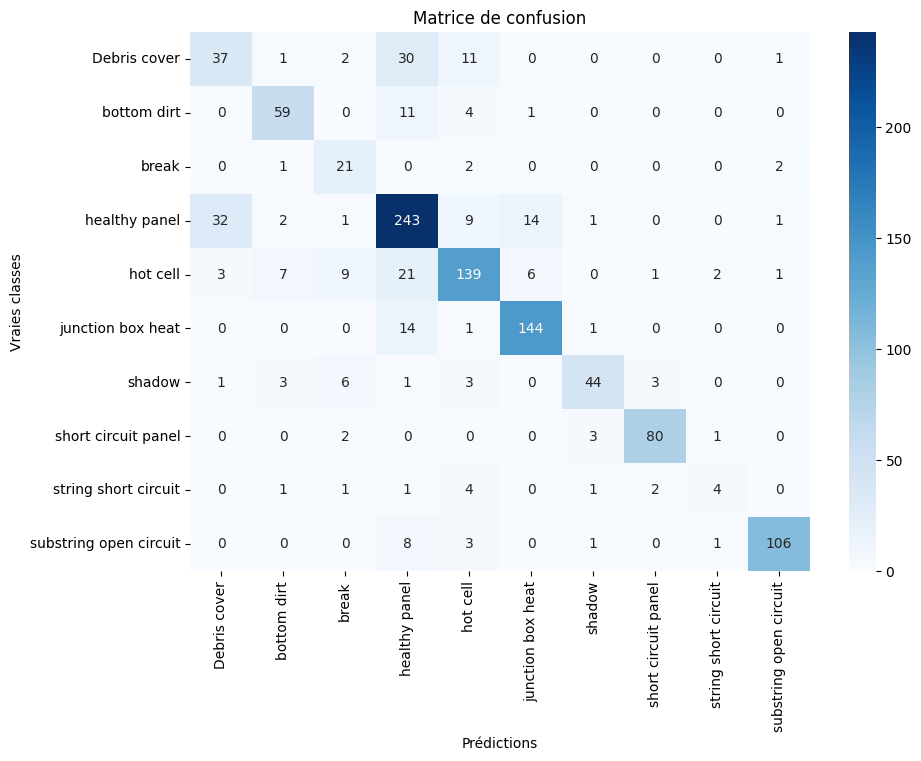

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.51      0.45      0.48        82
           bottom dirt       0.80      0.79      0.79        75
                 break       0.50      0.81      0.62        26
         healthy panel       0.74      0.80      0.77       303
              hot cell       0.79      0.74      0.76       189
     junction box heat       0.87      0.90      0.89       160
                shadow       0.86      0.72      0.79        61
   short circuit panel       0.93      0.93      0.93        86
  string short circuit       0.50      0.29      0.36        14
substring open circuit       0.95      0.89      0.92       119

              accuracy                           0.79      1115
             macro avg       0.75      0.73      0.73      1115
          weighted avg       0.79      0.79      0.79      1115



In [100]:
# Pipeline finale = extraction des features GLCM/entropie/canny/pixels bruts + SMOTETomek + Random Forest
default_steps['hog']="drop"
default_steps['glcm']= GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                     glcm_props=['contrast','energy'])
default_steps['entropie'] = EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)
default_steps['canny'] = EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)
default_steps['brut'] = PixelsBrutsExtractor(image_size=(30,55))
default_steps['scaler']= "passthrough"
default_steps['reduction']= "passthrough"
default_steps['sampler']= SMOTETomek()
default_steps['clf'] = RandomForestClassifier()

my_pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('hog', default_steps['hog']),
        ('glcm', default_steps['glcm']),
        ('entropie',default_steps['entropie']),
        ('canny',default_steps['canny']),
        ('brut',default_steps['brut'])
    ])),
    ('scaler', default_steps['scaler']),
    ('reduction', default_steps['reduction']),
    ('sampler', default_steps['sampler']),
    ('clf', default_steps['clf'])
])

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

On a une **généralisation correcte: 79% d'accuracy et 73% de f1-score**, mais la performance est moins bonne que la modélisation basée sur le classifieur SVM par exemple.

Certains défauts ont du mal à être détectés  : 
- "Debris cover" => souvent confondus avec "Healthy Panel"
- "String short circuit" (classe peu représentée dans le dataset) => mauvais scores en précision et en rappel
- Certains défauts sont classés "Break" à tort (précision faible)

### Avec retrait des images carrées mises en doute...

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog', 'drop'),
                                                ('glcm',
                                                 GLCMExtractor(glcm_distances=[8],
                                                               glcm_props=['contrast',
                                                                           'energy'])),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny',
                                                 EdgeDensityExtractor(canny_threshold1=70,
                                                                      canny_threshold2=140)),
                                                ('brut',
                                                 PixelsBrutsExtractor())])),
                ('scaler', 'passthrough'), ('reduction', 'passthrough'),
                ('sampler', SMOTETomek()), ('clf', RandomForestClassifier())])

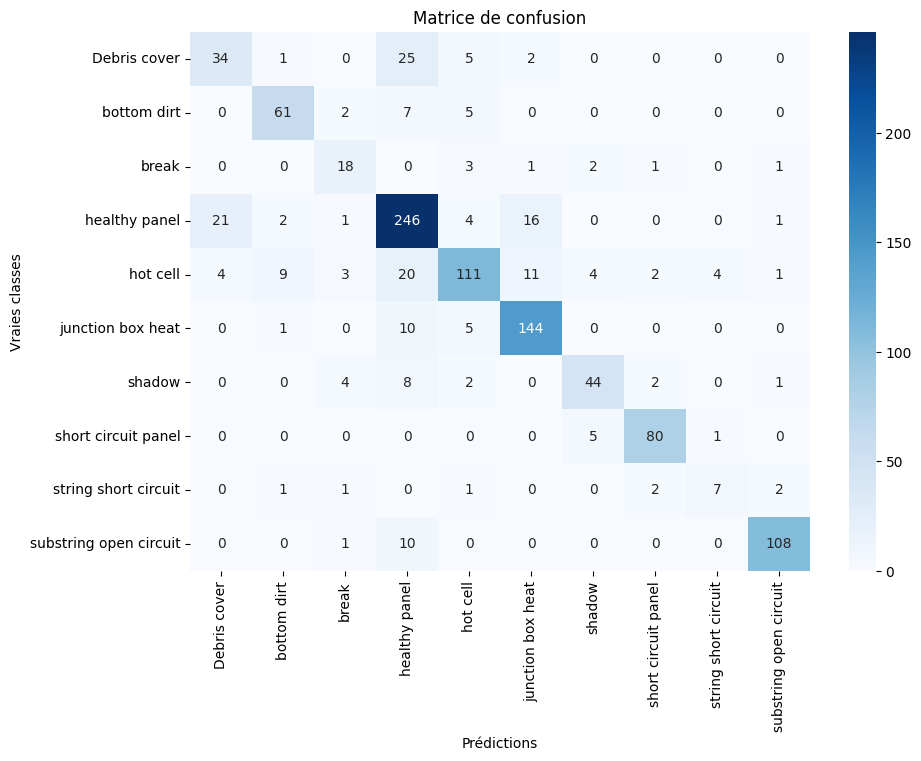

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.58      0.51      0.54        67
           bottom dirt       0.81      0.81      0.81        75
                 break       0.60      0.69      0.64        26
         healthy panel       0.75      0.85      0.80       291
              hot cell       0.82      0.66      0.73       169
     junction box heat       0.83      0.90      0.86       160
                shadow       0.80      0.72      0.76        61
   short circuit panel       0.92      0.93      0.92        86
  string short circuit       0.58      0.50      0.54        14
substring open circuit       0.95      0.91      0.93       119

              accuracy                           0.80      1068
             macro avg       0.76      0.75      0.75      1068
          weighted avg       0.80      0.80      0.80      1068



In [42]:
# Découpage train/test avec retrait des images carrées
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60",removeCarre=True)

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

Suite au retrait des images carrées, les f1-score peuvent varier légèrement sur les différentes classes mais la performance reste similaire au global.

### Avec le découpage proposé par les constructeurs du dataset...

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog', 'drop'),
                                                ('glcm',
                                                 GLCMExtractor(glcm_distances=[8],
                                                               glcm_props=['contrast',
                                                                           'energy'])),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny',
                                                 EdgeDensityExtractor(canny_threshold1=70,
                                                                      canny_threshold2=140)),
                                                ('brut',
                                                 PixelsBrutsExtractor())])),
                ('scaler', 'passthrough'), ('reduction', 'passthrough'),
                ('sampler', SMOTETomek()), ('clf', RandomForestClassifier())])

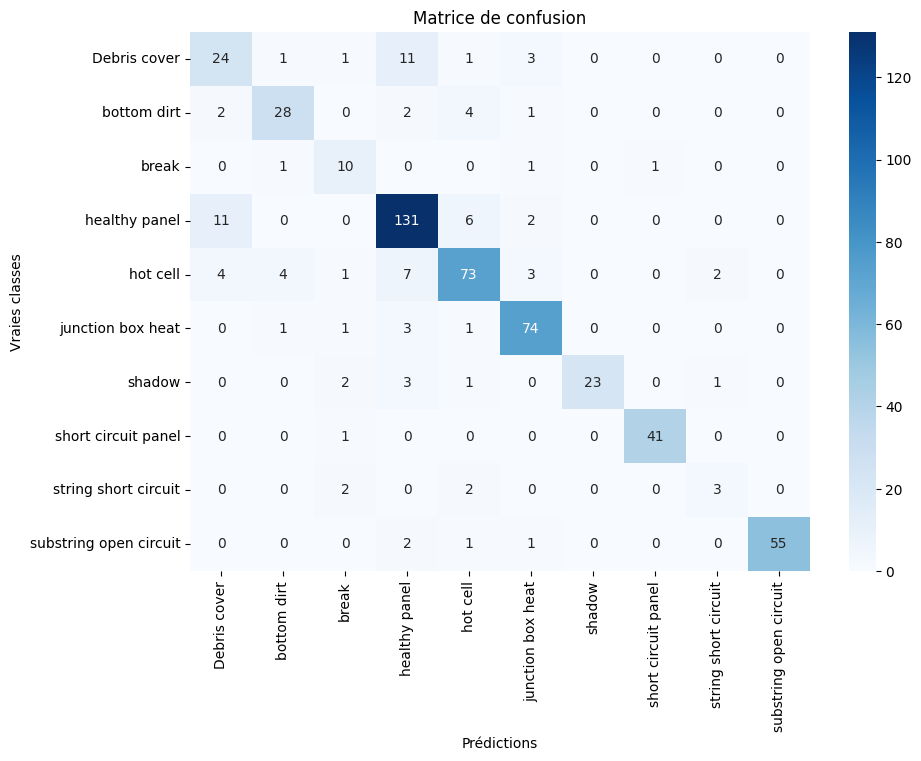

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.59      0.59      0.59        41
           bottom dirt       0.80      0.76      0.78        37
                 break       0.56      0.77      0.65        13
         healthy panel       0.82      0.87      0.85       150
              hot cell       0.82      0.78      0.80        94
     junction box heat       0.87      0.93      0.90        80
                shadow       1.00      0.77      0.87        30
   short circuit panel       0.98      0.98      0.98        42
  string short circuit       0.50      0.43      0.46         7
substring open circuit       1.00      0.93      0.96        59

              accuracy                           0.84       553
             macro avg       0.79      0.78      0.78       553
          weighted avg       0.84      0.84      0.84       553



In [44]:
# Découpage train / test proposé par les constructeurs du dataset
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60",originalTrainTest=True)

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

Avec le découpage proposé par les constructeurs du dataset (90% / 10%), on améliore les résultats : **84% d'accuracy et 78% de f1-score**. Pour rappel dans leur article de recherche, le meilleur score atteint avec des modèles de Deep Learning pour les images 110x60 était de 92% d'accuracy et 91% de f1-score.

### Avec le format d'images original (avant recadrage / découpage en 110x60)...

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('hog', 'drop'),
                                                ('glcm',
                                                 GLCMExtractor(glcm_distances=[8],
                                                               glcm_props=['contrast',
                                                                           'energy'])),
                                                ('entropie',
                                                 EntropyExtractor(bins=20)),
                                                ('canny',
                                                 EdgeDensityExtractor(canny_threshold1=70,
                                                                      canny_threshold2=140)),
                                                ('brut',
                                                 PixelsBrutsExtractor())])),
                ('scaler', 'passthrough'), ('reduction', 'passthrough'),
                ('sampler', SMOTETomek()), ('clf', RandomForestClassifier())])

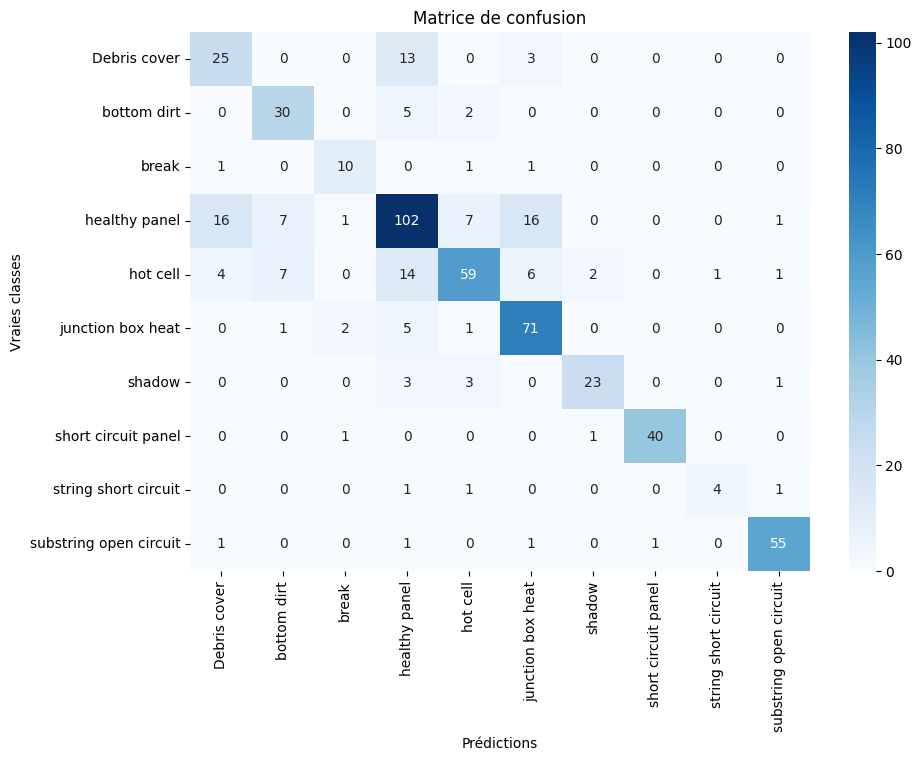

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.53      0.61      0.57        41
           bottom dirt       0.67      0.81      0.73        37
                 break       0.71      0.77      0.74        13
         healthy panel       0.71      0.68      0.69       150
              hot cell       0.80      0.63      0.70        94
     junction box heat       0.72      0.89      0.80        80
                shadow       0.88      0.77      0.82        30
   short circuit panel       0.98      0.95      0.96        42
  string short circuit       0.80      0.57      0.67         7
substring open circuit       0.93      0.93      0.93        59

              accuracy                           0.76       553
             macro avg       0.77      0.76      0.76       553
          weighted avg       0.76      0.76      0.76       553



In [45]:
# Découpage train / test proposé par les constructeurs du dataset sur les images originales
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="Ori",originalTrainTest=True)

# Entraînement sur train et évaluation sur test
my_pipeline.fit(X_train,y_train)
evaluate_pipeline(my_pipeline,X_test,y_test)

On constate sans surprise une baisse des résultats par rapport au format 110x60, mais cela reste tout-à-fait honorable : 76% d'accuracy et 76% de f1-score.

# 9. Interprétabilité

On récupère les données d'entrée extraites (avant rééchantillonnage). Nous allons étudier l'interprétabilité de ces données par le classifieur Random Forest.

In [ ]:
# On reprend notre pipeline avec les paramètres optimisés
interp_pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('glcm', GLCMExtractor(image_size=(60,110),glcm_distances=[8],glcm_angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                     glcm_props=['contrast','energy'])),
        ('entropie',EntropyExtractor(image_size=(60,110),radius=4, bins=20, include_histogram=True)),
        ('canny',EdgeDensityExtractor(image_size=(60,110),canny_threshold1=70,canny_threshold2=140)),
        ('brut',PixelsBrutsExtractor(image_size=(30,55)))
    ])),
    ('sampler', SMOTETomek()),
    ('clf', RandomForestClassifier())
])

# Découpage train / test par défaut, entraînement et prédiction
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60")
interp_pipeline.fit(X_train,y_train)
y_pred = interp_pipeline.predict(X_test)
y_pred_proba = interp_pipeline.predict_proba(X_test)

# On récupère l'ensemble train après l'extraction des features (1ère étape de la pipeline)
start_pipe = interp_pipeline[0]
X_train_transformed = start_pipe.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed,index = X_train.index,columns=start_pipe.get_feature_names_out())
display (X_train_transformed)

# On récupère l'ensemble test après l'extraction des features (1ère étape de la pipeline)
X_test_transformed = start_pipe.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed,index = X_test.index,columns=start_pipe.get_feature_names_out())
display (X_test_transformed)

# On récupère le classifieur Random Forest (étape finale de la pipeline)
rfc = interp_pipeline[-1]


glcm__contrast_d8_a0  glcm__contrast_d8_a45  glcm__contrast_d8_a90  \
5277             26.582692              30.007479              35.348039   
3825            518.968007             461.527244             124.667810   
3171             39.394930             328.276709             578.534641   
2697            283.893881             196.925926             103.906373   
1610            133.055769             101.824964              58.048693   
...                    ...                    ...                    ...   
2136             80.748077             102.305377              89.254902   
5554             57.438636             164.672543             172.968627   
709              34.906469             312.258013             238.883333   
4055            386.135490             382.759081             132.929248   
4511            182.282168             242.644053             106.911275   

      glcm__contrast_d8_a135  glcm__energy_d8_a0  glcm__energy_d8_a45  \
5277               29.896902            0.066970             0.060525   
3825              461.029736            0.048365             0.039286   
3171              402.710648            0.049653             0.035968   
2697              188.061075            0.069685             0.069924   
1610              111.390313            0.035063             0.035633   
...                      ...                 ...                  ...   
2136              123.646546            0.049071             0.045420   
5554              161.161859            0.070572             0.054919   
709               301.303419            0.051100             0.046565   
4055              288.358440            0.032792             0.031720   
4511              238.851318            0.052878             0.045205   

      glcm__energy_d8_a90  glcm__energy_d8_a135  entropie__entropy_mean  \
5277             0.065109              0.061961                2.451598   
3825             0.039617              0.040626                3.293134   
3171             0.032550              0.035369                3.273273   
2697             0.077456              0.070156                2.734329   
1610             0.040134              0.035557                3.197214   
...                   ...                   ...                     ...   
2136             0.045405              0.046629                3.357935   
5554             0.052017              0.056020                2.850234   
709              0.045087              0.046863                3.191652   
4055             0.034999              0.031639                3.345156   
4511             0.045442              0.045511                3.421109   

      entropie__entropy_std  entropie__entropy_min  entropie__entropy_max  \
5277               0.725022               0.475432               4.349875   
3825               1.082722               0.714976               5.376629   
3171               0.981114               0.591673               5.124914   
2697               0.963642               0.474133               5.369812   
1610               0.718459               0.998974               5.095176   
...                     ...                    ...                    ...   
2136               0.751797               0.730017               5.240218   
5554               0.861943               0.549098               4.648956   
709                0.840124               1.043059               5.110902   
4055               0.864960               0.863121               5.247363   
4511               0.860634               0.676197               5.136842   

      entropie__entropy_median  entropie__entropy_skew  \
5277                  2.414306                0.041342   
3825                  3.408128               -0.189294   
3171                  3.297034               -0.137229   
2697                  2.785627                0.124911   
1610                  3.266802               -0.382083   
...                        ...            

glcm__contrast_d8_a0  glcm__contrast_d8_a45  glcm__contrast_d8_a90  \
4376            229.752448             267.934829              80.282026   
2109            371.572028             455.127671             393.717647   
4508             71.128497             115.555734              76.211111   
3203            164.290909             540.293981             669.668301   
1246             41.665385              38.996617              22.659641   
...                    ...                    ...                    ...   
1382            229.514161             225.886574              53.178105   
3699           1423.098601            1119.162037             325.853922   
2222            144.653846             137.519409              78.864706   
4119            371.648601             304.788283             110.071242   
1401            121.284790             109.073540              50.236275   

      glcm__contrast_d8_a135  glcm__energy_d8_a0  glcm__energy_d8_a45  \
4376              271.337251            0.066946             0.063159   
2109              419.399217            0.040402             0.037966   
4508               94.725427            0.065417             0.061300   
3203              575.904558            0.034487             0.028147   
1246               46.785969            0.067722             0.060232   
...                      ...                 ...                  ...   
1382              213.838319            0.066026             0.061648   
3699             1140.641738            0.018551             0.019452   
2222              159.585470            0.058675             0.053556   
4119              271.189459            0.039424             0.040142   
1401              103.543625            0.038951             0.038621   

      glcm__energy_d8_a90  glcm__energy_d8_a135  entropie__entropy_mean  \
4376             0.066521              0.062548                2.991665   
2109             0.042160              0.037942                3.495797   
4508             0.067262              0.061599                2.872772   
3203             0.026406              0.027373                3.463989   
1246             0.067595              0.061880                2.824258   
...                   ...                   ...                     ...   
1382             0.060911              0.060488                2.961738   
3699             0.023432              0.019839                4.088740   
2222             0.052975              0.052088                3.066219   
4119             0.043886              0.039446                3.224559   
1401             0.043451              0.039450                3.043846   

      entropie__entropy_std  entropie__entropy_min  entropie__entropy_max  \
4376               0.832819               0.904434               5.027889   
2109               0.800959               0.877349               5.369812   
4508               0.800549               0.642064               4.739098   
3203               0.872304               0.997294               5.369812   
1246               0.689869               0.958054               4.532268   
...                     ...                    ...                    ...   
1382               0.952937               0.474133               5.053509   
3699               0.669233               1.445136               5.451445   
2222               0.793126               0.730017               5.209963   
4119               0.912975               0.863121               5.084098   
1401               0.678000               0.918165               5.094102   

      entropie__entropy_median  entropie__entropy_skew  \
4376                  3.032633               -0.060675   
2109                  3.467136               -0.052657   
4508                  2.854674                0.013408   
3203                  3.427447               -0.024769   
1246                  2.837227               -0.115546   
...                        ...            

### Interprétabilité spécifique

Le classifieur Random Forest permet une **interprétabilité spécifique**. Afin de mieux comprendre l'**importance des features**, nous allons les regrouper par catégorie : GLCM Contraste, GLCM Energie, Entropie, Canny, Pixels bruts.

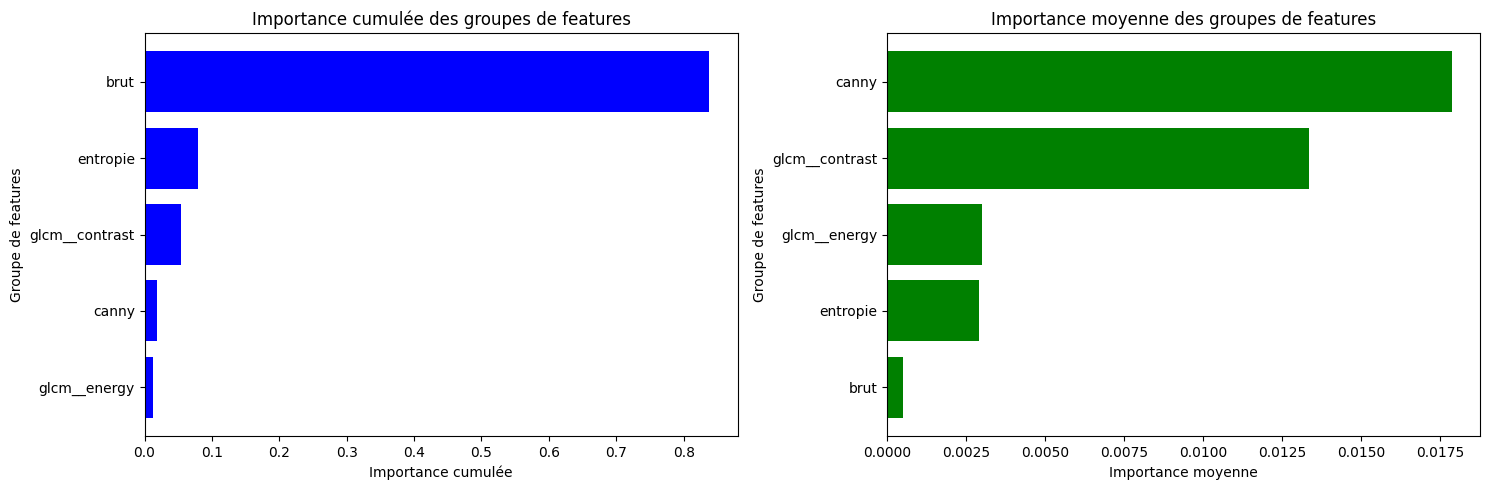

In [ ]:
# Récupération de l'importance des features utilisées par Random Forest
importances = rfc.feature_importances_

# Regroupement des features par catégorie 
feature_groups = X_test_transformed.columns.str.extract(r'^(canny|glcm__contrast|glcm__energy|brut|entropie)', expand=False)
importances_df = pd.DataFrame({
    "feature": X_test_transformed.columns,
    "importance": importances,
    "groupe": feature_groups
})

# Importance cumulée par catégorie
group_importance = importances_df.groupby("groupe")["importance"].sum().sort_values()

# Importance moyenne par catégorie
group_mean = importances_df.groupby("groupe")["importance"].mean().sort_values()

# Affichage sur 2 graphes
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.barh(group_importance.index, group_importance, color="blue")
plt.title("Importance cumulée des groupes de features")
plt.xlabel("Importance cumulée")
plt.ylabel("Groupe de features")

plt.subplot(122)
plt.barh(group_mean.index, group_mean, color="green")
plt.title("Importance moyenne des groupes de features")
plt.xlabel("Importance moyenne")
plt.ylabel("Groupe de features")

plt.tight_layout()
plt.show()

Le graphique de gauche (importance cumulée) indique la contribution d'un groupe de features à notre modèle, celui de droite (importance moyenne) prend en compte le nombre de features et indique plutôt l'efficacité des features du groupe en question. Ainsi on s'aperçoit que : 
- **les pixels bruts contribuent le plus à la classification (importance globale > 80%)**. Néanmoins ceci est principalement dû à leur nombre : ils représentent près de 98% des features. Le graphique à droite relativise bien l'importance d'un pixel seul.
- **la densité de contour (Canny) et le contraste sont les features les plus efficaces dans la classification**. Cela rejoint les résultats des tests statistiques effectués lors de l'analyse exploratoire.

### Interprétabilité SHAP globale

Nous allons maintenant utiliser le modèle d'interprétabilité **SHAP Tree Explainer** qui est bien adapté à un modèle du type Random Forest. On commence par l'interprétabilité globale sur l'ensemble des classes.

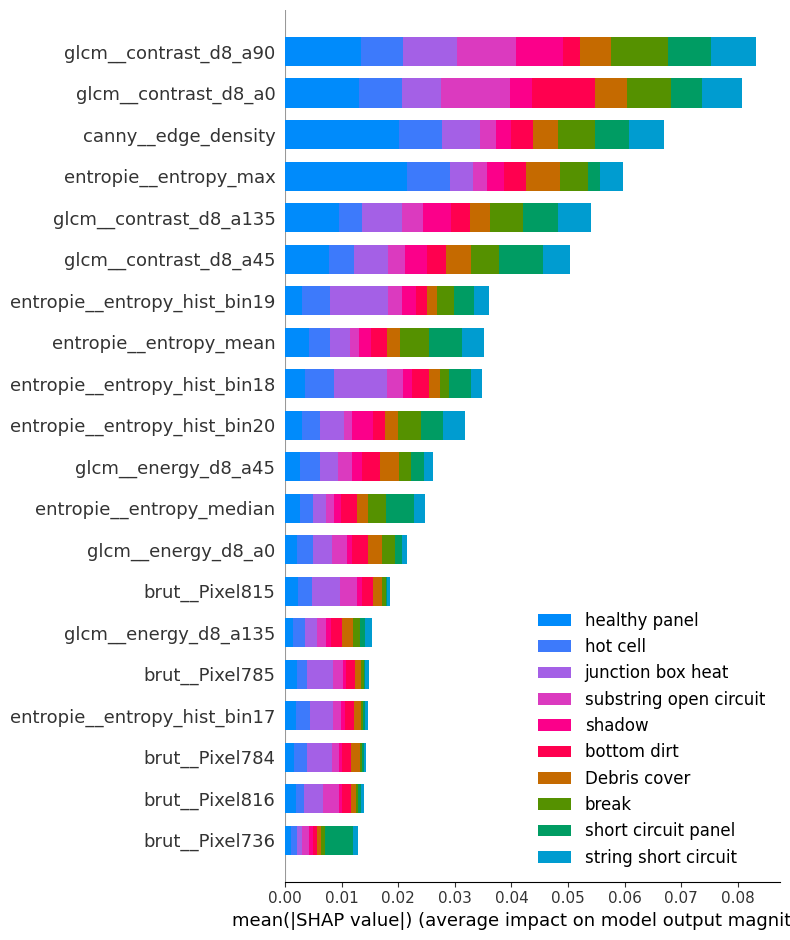

In [18]:
# Interprétabilité GLOBALE avec SHAP TreeExplainer
import shap

# Créer un explainer SHAP pour le modèle Random Forest
explainer = shap.TreeExplainer(rfc)

# Calculer les shap-values pour le jeu de test (après extraction des features)
shap_values = explainer.shap_values(X_test_transformed)

# Afficher l'interprétation globale
shap.summary_plot(shap_values,X_test_transformed,plot_type='bar',class_names=rfc.classes_)

On peut déduire de ces Shap values :
- l'**importance du contraste dans les 4 directions**. Par exemple pour détecter les défauts "substring open circuit" et "bottom dirt" avec le contraste horizontal.
- l'**importance de la densité de contours** calculée avec Canny, notamment pour la classe "healthy" qui doit avoir une densité de contours très faible.
- l'**importance de la carte d'entropie, particulièrement les valeurs élevées** (le max et les valeurs hautes de l'histogramme figurent parmi les plus importantes features) ainsi que l'entropie moyenne / médiane.
- les pixels bruts en tant que tels ne figurent pas parmi les features les plus importantes, mais on peut noter que certains d'entre eux sont relativement impactants pour la classe "junction box heat" dont les défauts sont toujours localisés aux mêmes emplacements du panneau.

### Interprétabilité SHAP locale

**On commence par interpréter une image sur laquelle le modèle a vu juste**

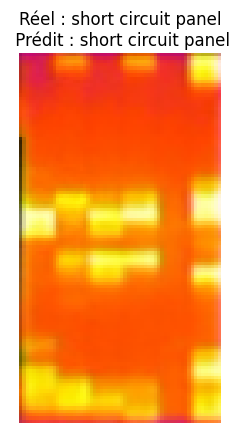

In [20]:
# On choisit une instance de test à expliquer
instance_idx = 20
img = cv2.imread(X_test.iloc[instance_idx]["Chemin"])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Réel : {y_test.iloc[instance_idx]}\n Prédit : {y_pred[instance_idx]}")
plt.show()

In [41]:
predicted_class_idx = rfc.classes_.tolist().index("short circuit panel")
print (f"Probabilité prédiction classe short circuit panel : {y_pred_proba[instance_idx][predicted_class_idx]}")

Probabilité prédiction classe short circuit panel : 0.99


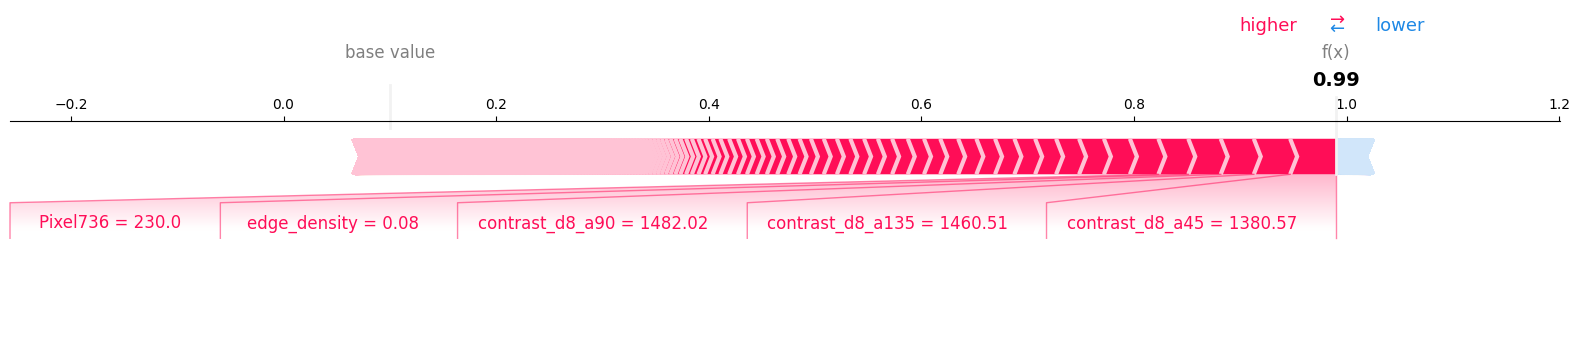

In [ ]:
import re

# Force-plot SHAP sur la classe prédite
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[instance_idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[instance_idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = [re.sub(r'^.*?__', '', col) for col in X_test_transformed.columns], # On coupe le début du nom de feature pour la présentation du graphique
    contribution_threshold = 0.03, # On n'affiche que les features les + importantes
    matplotlib=True,
)

On constate sur cette image que le très fort contraste et la densité de contours élevée (8%) ont contribué au classement de cette image en short circuit panel. Ce type de défauts entraîne effectivement de brusques variations de température sur le panneau.

**On observe maintenant une image sur laquelle le modèle s'est trompé**

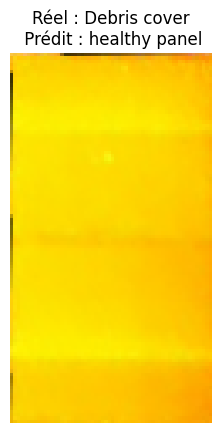

In [84]:
# On choisit une instance de test à expliquer
instance_idx = 31
img = cv2.imread(X_test.iloc[instance_idx]["Chemin"])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Réel : {y_test.iloc[instance_idx]}\n Prédit : {y_pred[instance_idx]}")
plt.show()

In [94]:
real_class_idx = rfc.classes_.tolist().index("Debris cover")
print (f"Probabilité prédiction classe Debris cover (réel) : {y_pred_proba[instance_idx][real_class_idx]}")
predicted_class_idx = rfc.classes_.tolist().index("healthy panel")
print (f"Probabilité prédiction classe healthy panel : {y_pred_proba[instance_idx][predicted_class_idx]}")

Probabilité prédiction classe Debris cover (réel) : 0.23
Probabilité prédiction classe healthy panel : 0.34


On va essayer de voir pourquoi on le modèle prédit la classe Healthy panel plutôt que Debris cover sur cette image (erreur fréquente d'après la matrice de confusion)

Importance des features pour la classe réelle (Debris cover) :


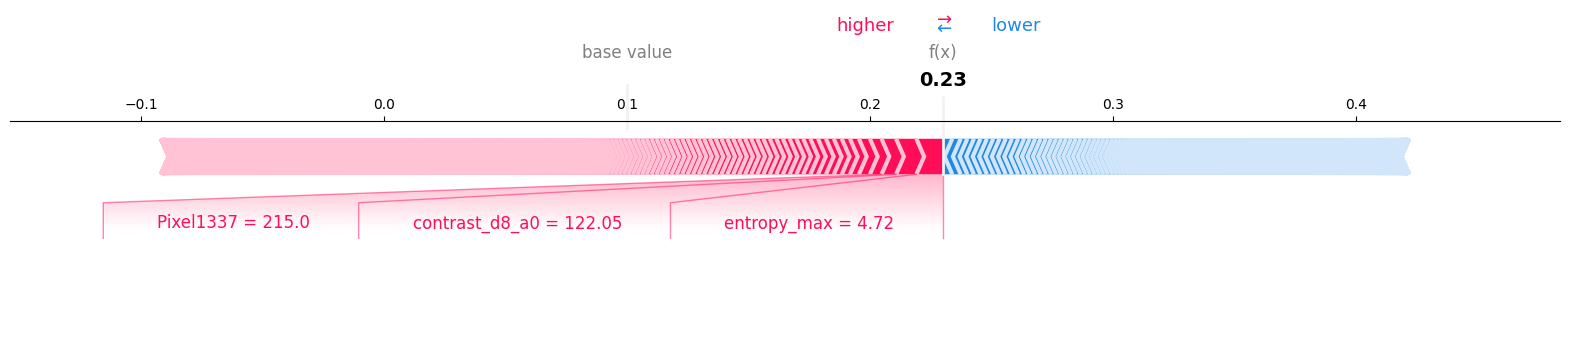

--------------------
Importance des features pour la classe prédite (healthy panel) :


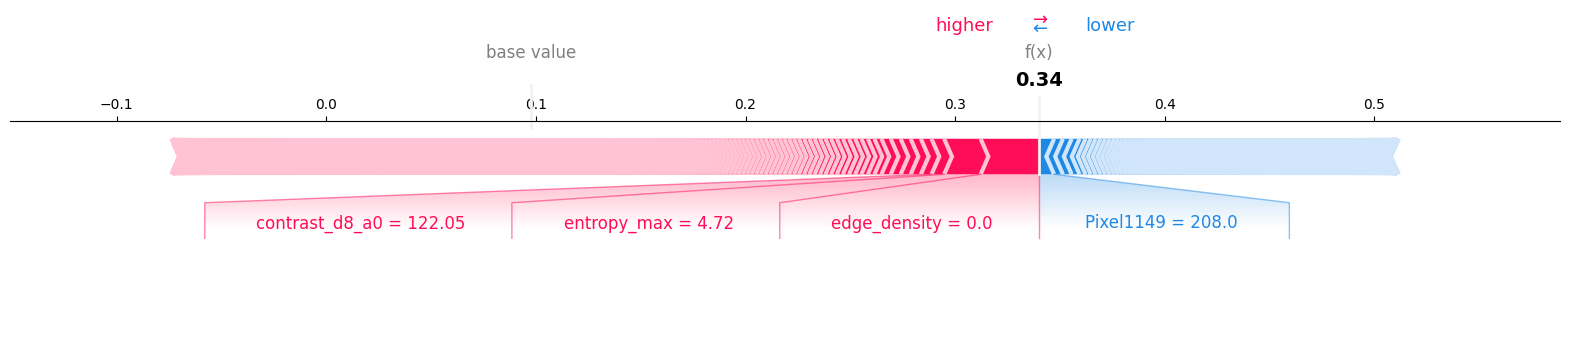

In [95]:
# Force-plot SHAP sur la classe réelle
print ("Importance des features pour la classe réelle (Debris cover) :")
shap.force_plot(
    explainer.expected_value[real_class_idx], 
    shap_values[instance_idx,:,real_class_idx], 
    np.round(X_test_transformed.iloc[instance_idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = [re.sub(r'^.*?__', '', col) for col in X_test_transformed.columns], # On coupe le début du nom de feature pour la présentation du graphique
    contribution_threshold = 0.01, # On n'affiche que les features les + importantes
    matplotlib=True,
)
print ("-"*20)

# Force-plot SHAP sur la classe prédite
print ("Importance des features pour la classe prédite (healthy panel) :")
shap.force_plot(
    explainer.expected_value[predicted_class_idx], 
    shap_values[instance_idx,:,predicted_class_idx], 
    np.round(X_test_transformed.iloc[instance_idx].values,2), # On arrondit les valeurs pour la présentation du graphique
    feature_names = [re.sub(r'^.*?__', '', col) for col in X_test_transformed.columns], # On coupe le début du nom de feature pour la présentation du graphique
    contribution_threshold = 0.01, # On n'affiche que les features les + importantes
    matplotlib=True,
)

Sur cette image, on constate par exemple que les 2 features qui contribueraient le plus à la classe (réelle) Debris cover sont une entropie maximum faible et également un contraste horizontal faible. Néanmoins, ces 2 caractéristiques sont également importantes pour classer cette image comme Healthy panel. L'absence de contours détectés sur cette image parachève la victoire, à tort, de la classe Healthy panel.

Les Debris Cover engendrent en général des perturbations de température trop faibles pour les distinguer facilement d'un panneau sain.

**Si le modèle basé sur Random Forest n'est pas le plus performant (comparé à SVM ou au Deep learning), il a l'avantage d'être plutôt bien interprétable.**

# 10. Généralisation hors dataset

Voyons sur quelques images de panneaux trouvées **hors dataset** si notre modèle arrive à détecter des défauts

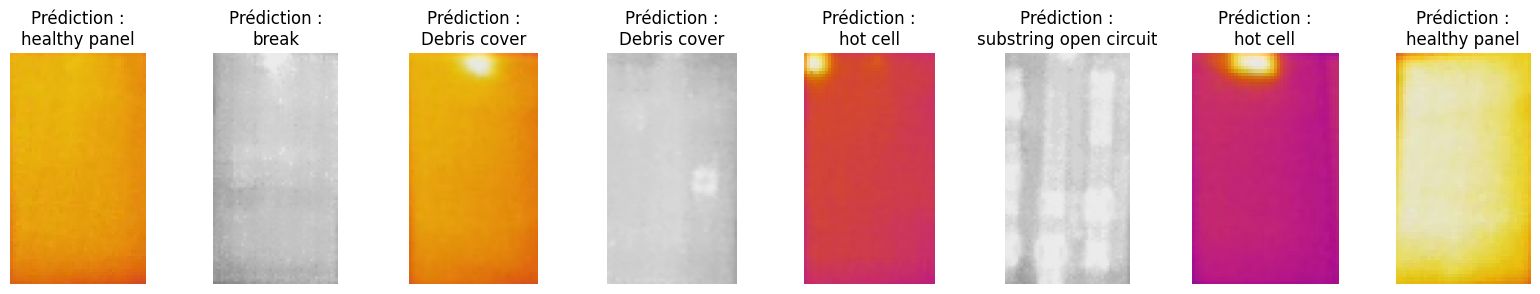

In [101]:
# On revient sur le découpage train / test de départ
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60")
my_pipeline.fit(X_train,y_train)

# Quelques images de test hors dataset pour la prédiction
plt.figure(figsize=(20, 3))
for i,unit_test_path in enumerate(["UT_images_ext/UT_healthy.png",
                                   "UT_images_ext/UT_junction_box.png",
                                   "UT_images_ext/UT_junction_box_2.png",
                                   "UT_images_ext/UT_one_cell.png",
                                   "UT_images_ext/UT_one_cell_2.png",
                                   "UT_images_ext/UT_multi_cell.png",
                                   "UT_images_ext/UT_multi_cell_2.png",
                                   "UT_images_ext/UT_module.png"]):
    unit_test = pd.DataFrame({"Chemin":[unit_test_path]})
    unit_pred = my_pipeline.predict(unit_test)
    plt.subplot(1, 8, i+1)
    img = cv2.imread(unit_test_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Prédiction :\n{unit_pred[0]}")
plt.show()

Le modèle basé sur Random Forest arrive à détecter des défauts. Sur cet échantillon externe au dataset, les prédictions semblent même plus pertinentes que le modèle basé sur SVM, pourtant plus performant sur le dataset PVF-10.